In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py

import windIO
import wind
import windWT as wt
import windCAD
import windOF as foam
import windCodes

import winsound

from matplotlib.ticker import FuncFormatter

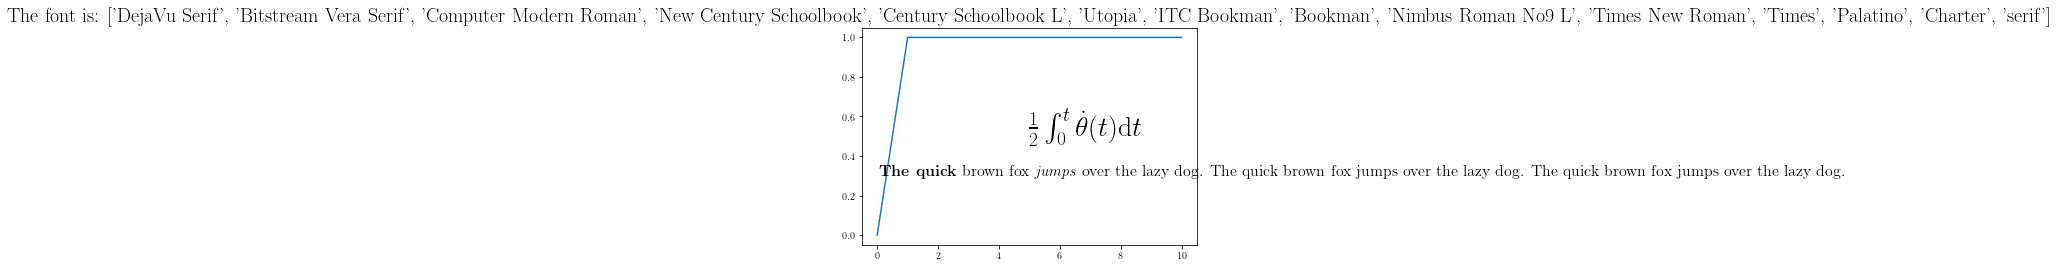

In [3]:
# # Reset to the default font settings
# plt.rcdefaults()

# # turn on latex rendering for matplotlib with Times New Roman font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# # change the font to Garamond
# plt.rc('text', usetex=False)
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Garamond'
# plt.rcParams['font.sans-serif'] = 'Garamond'

# # change the font to Times New Roman
# plt.rc('text', usetex=False)
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.serif'] = 'Times New Roman'
# plt.rcParams['font.sans-serif'] = 'Times New Roman'

# test the font
plt.figure()
plt.plot([0,1,10],[0,1,1])
txt = "The font is: " + str(plt.rcParams['font.serif'])
plt.title(txt,fontsize=20)
complexEquation = r"$\frac{1}{2} \int_0^t \dot{\theta}(t) \mathrm{d}t$"
plt.text(5,0.5,complexEquation,fontsize=28)
multilineTxt = r"\textbf{The quick} brown fox \textit{jumps} over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog."
plt.text(0.05,0.3,multilineTxt,fontsize=16)
plt.show()


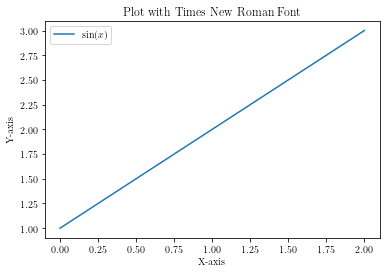

In [4]:
import matplotlib.pyplot as plt

# Set the font for regular text directly
plt.rcParams['font.family'] = 'Times New Roman'

# Example plot with Times New Roman font for regular text
plt.plot([1, 2, 3], label=r'$\sin(x)$')
plt.title('Plot with Times New Roman Font')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()


## Basic definitions

In [5]:
les_dir = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/"

dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"
dir_wtVl_tngE3 = r"D:/tempData_depot/simData_CandC/wt_tngE3/"

runIDs = ['p1', 'p2', 'p3', 'p4', 'p5',]

dir_wtCp_tngE2 = [r"F:/TNG/rawHFPI/tngE2"+x+"/" for x in runIDs]
dir_wtCp_tngE3 = [r"F:/TNG/rawHFPI/tngE3"+x+"/" for x in runIDs]

saveFigs = False
figDir = les_dir+ r"__plots/"
if not os.path.exists(figDir):
    os.makedirs(figDir)

In [6]:
caseDict = {
    'AoAs':     [0.0, 10.0, 20.0, 30.0, 40.0, 45.0, 50.0, 60.0, 70.0, 80.0, 90.0],
    'profile':  {'dir':les_dir+'tngE2.ed.t5.r2.s2', 'probeName':'prof_x0_y0'},
    'p0_Z':     1.0, # [m] probe height
    0.0:        {'dir':les_dir+'tngE2.00d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    10.0:       {'dir':les_dir+'tngE2.10d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    20.0:       {'dir':les_dir+'tngE2.20d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    30.0:       {'dir':les_dir+'tngE2.30d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    40.0:       {'dir':les_dir+'tngE2.40d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    45.0:       {'dir':les_dir+'tngE2.45d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    50.0:       {'dir':les_dir+'tngE2.50d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    60.0:       {'dir':les_dir+'tngE2.60d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    70.0:       {'dir':les_dir+'tngE2.70d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    80.0:       {'dir':les_dir+'tngE2.80d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    90.0:       {'dir':les_dir+'tngE2.90d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
}


In [7]:
B = 0.2744
D = 0.183
lScl=1/50.0

Hr = 0.08  # ridge height
roofSlope = np.rad2deg(np.arctan(0.25/12))  # roof slope
He = Hr - D/2.0*np.sin(np.deg2rad(roofSlope))  # eaves height
Havg = np.mean([Hr, He])
H = Havg  # average roof height
print("Hr = {:.5g} m, He = {:.5g} m, Havg = {:.5g} m".format(Hr, He, Havg))

areaFactor_toFSm2 = (1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

fluidDensity = 1.225  # only for wind tunnel
fluidKinematicViscosity = 1.48e-5

badTaps = None
# badTaps = [1316, 1807, 2609,]
badTaps = [1807, 2609,]


Hr = 0.08 m, He = 0.078094 m, Havg = 0.079047 m


## Building Geometry

In [8]:
tapFile = r"D:/tempData_depot/simData_CandC/tngTapDefinition.csv"
tapInfo = pd.read_csv(tapFile)

faceID = [1,2,3,4,5,6]
name = ['Roof_1','Roof_2','Wall_1','Wall_2','Wall_3','Wall_4']
note = ['','','','','','']
origin = [[0,0,0.08],
          [0,-0.0915,0.07809375],
          [-0.1372,0,0],
          [0,-0.0915,0],
          [0.1372,0,0],
          [0,0.0915,0],]
basisVectors = [[[1,0,0],[0,0.999783057,0.020828814],[0,-0.020828814,0.999783057]],
                [[1,0,0],[0,0.999783057,-0.020828814],[0,0.020828814,0.999783057]],
                [[0,0,-1],[-1,0,0],[0,1,0]],
                [[1,0,0],[0,0,-1],[0,1,0]],
                [[0,0,1],[1,0,0],[0,1,0]],
                [[-1,0,0],[0,0,1],[0,1,0]],]

origin_plt = [[0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              ]

basisVectors_plt = [[[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    ]
vertices = [[[-0.091519855,-0.1372],[0,-0.1372],[0,0.1372],[-0.091519855,0.1372],[-0.091519855,-0.1372]],
            [[0,-0.1372],[0.091519855,-0.1372],[0.091519855,0.1372],[0,0.1372],[0,-0.1372]],
            [[-0.0915,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0,-0.1532],[-0.0915,-0.15510625],[-0.0915,-0.2332]],
            [[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,-0.1372]],
            [[-0.0915,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0,0.1532],[-0.0915,0.15510625],[-0.0915,0.2332]],
            [[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,-0.1372]],]

lineDfn_ABCD = {
    'A': {'faceID':4, 'start': [0.18559377, 0.01306269], 'end': [0.1075, 0.01306269], },
    'B': {'faceID':2, 'start': [0.0915, 0.01306269], 'end': [0, 0.01306269], },
    'C': {'faceID':1, 'start': [0, 0.01306269], 'end': [-0.0915, 0.01306269], },
    'D': {'faceID':6, 'start': [-0.1075, 0.01306269], 'end': [-0.18559377, 0.01306269], },
    }
lineDfn_EFGH = {
    'E': {'faceID':5, 'start': [-0.0915, 0.18231127], 'end': [0.0915, 0.18231127], },
    'F': {'faceID':4, 'start': [0.13444109, 0.1372], 'end': [0.13444109, -0.1372], },
    'G': {'faceID':3, 'start': [0.0915, -0.18231127], 'end': [-0.0915, -0.18231127], },
    'H': {'faceID':6, 'start': [-0.13444109, -0.1372], 'end': [-0.13444109, 0.1372], },
    }
lineDfn_IJK = {
    'I': {'faceID':5, 'start': [0.09000327, 0.2332], 'end': [0.09000327, 0.15507505], },
    'J': {'faceID':2, 'start': [0.08950436, 0.1372], 'end': [0.08950436, -0.1372], },
    'K': {'faceID':3, 'start': [0.09000327, -0.15507505], 'end': [0.09000327, -0.2332], },
    }

lineDfn_L = {
    'L': {'faceID':2, 'start': [0.08351745, 0.1372], 'end': [0.08351745, -0.1372], },
    }
lineDfn_M = {
    'M': {'faceID':2, 'start': [0.07603382, 0.1372], 'end': [0.07603382, -0.1372], },
    }
lineDfn_N = {
    'N': {'faceID':2, 'start': [0.0915, 0.1372], 'end': [0.02963527, -0.1372], },
    }
lineDfn_OP = {
    'O': {'faceID':2, 'start': [0.0915, 0.1372], 'end': [0, 0.10655273], },
    'P': {'faceID':1, 'start': [0, 0.10655273], 'end': [-0.0915, 0.07590545], },
    }


In [9]:
# Zone Dict definitions

zoneDict_NBCC = [
        {    # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[-0.091519855,-0.1372],[-0.071519855,-0.1372],[-0.071519855,-0.1172],[-0.091519855,-0.1172],[-0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[-0.091519855,0.1172],[-0.071519855,0.1172],[-0.071519855,0.1372],[-0.091519855,0.1372],[-0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[-0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[-0.071519855,-0.1172],[-0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[-0.091519855,-0.1172],[-0.071519855,-0.1172],[-0.071519855,0.1172],[-0.091519855,0.1172],[-0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[-0.071519855,0.1172],[0,0.1172],[0,0.1372],[-0.071519855,0.1372],[-0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[-0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[-0.071519855,0.1172],[-0.071519855,-0.1172]])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[0.091519855,-0.1372],[0.071519855,-0.1372],[0.071519855,-0.1172],[0.091519855,-0.1172],[0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[0.091519855,0.1172],[0.071519855,0.1172],[0.071519855,0.1372],[0.091519855,0.1372],[0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[0.071519855,-0.1172],[0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[0.091519855,-0.1172],[0.071519855,-0.1172],[0.071519855,0.1172],[0.091519855,0.1172],[0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[0.071519855,0.1172],[0,0.1172],[0,0.1372],[0.071519855,0.1372],[0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[0.071519855,0.1172],[0.071519855,-0.1172]])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

zoneDict_ASCE = [
        {    # Face 1
            0:['ASCE 7-22', 'Zone 3', np.array([[-0.0435, 0.1372], [-0.0915, 0.1372], [-0.0915, 0.0892], [-0.0755, 0.0892], [-0.0755, 0.1212], [-0.0435, 0.1212], [-0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[-0.0915, -0.0892], [-0.0915, -0.1372], [-0.0435, -0.1372], [-0.0435, -0.1212], [-0.0755, -0.1212], [-0.0755, -0.0892], [-0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [-0.0435, 0.1372], [-0.0435, 0.1212], [-0.0755, 0.1212], [-0.0755, 0.0892], [-0.0915, 0.0892], [-0.0915, -0.0892], 
                                                [-0.0755, -0.0892], [-0.0755, -0.1212], [-0.0435, -0.1212], [-0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [-0.0435, -0.0892], 
                                                [-0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [-0.0435, 0.0892], [-0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 2
            0:['ASCE 7-22', 'Zone 3', np.array([[0.0435, 0.1372], [0.0915, 0.1372], [0.0915, 0.0892], [0.0755, 0.0892], [0.0755, 0.1212], [0.0435, 0.1212], [0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[0.0915, -0.0892], [0.0915, -0.1372], [0.0435, -0.1372], [0.0435, -0.1212], [0.0755, -0.1212], [0.0755, -0.0892], [0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [0.0435, 0.1372], [0.0435, 0.1212], [0.0755, 0.1212], [0.0755, 0.0892], [0.0915, 0.0892], [0.0915, -0.0892], 
                                                [0.0755, -0.0892], [0.0755, -0.1212], [0.0435, -0.1212], [0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [0.0435, -0.0892], 
                                                [0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [0.0435, 0.0892], [0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 3
            0:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            2:['ASCE 7-22', 'Zone 5', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

# file = caseDir+'NBCC_zoneDict.json'
# with open(file, 'w') as f:
#     json.dump(zoneDict,f, indent=4, separators=(',', ':'))

In [10]:
# nominalPanelAreas=[1.0e-4, 2.45e-4, 4.8e-4, 7.1e-4, 1e-3], #[5e-5, 8e-5, 1.5e-4, 5e-4]
# nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,]  # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5.25e-4, 6.8e-4, 1.3e-3,]  # 5e-4 causes problems in ASCE 7-22 zone 2 
# nominalPanelAreas=[1.3e-3,]
# nominalPanelAreas=[4.8e-4, 7.2e-4, 1e-3]

faces_NBCC = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_NBCC[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_NBCC.append(fc)

faces_ASCE = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_ASCE[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_ASCE.append(fc)
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

In [11]:
bldg = wind.bldgCp(bldgName='TTU_1to50_TNG',
                faces=faces_ASCE,
                H=H, He=He, Hr=Hr,
                D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='GeomDefinition',
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='CCW',
                )
print(json.dumps(bldg.panelingErrors, indent=4, separators=(',', ':')))

Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.

{
    "Face 1":{
        "ASCE 7-22 -- Zone 3":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]":[],
            "tap idxs with weight errors":{
                "A=4.4e-05":[],
                "A=8.15e-05":[],
                "A=0.00013":[],
                "A=0.000525":[],
                "A=0.00068":[],
                "A=0.0013":[]
            }
        },
        "ASCE 7-22 -- Zone 2":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]":[],
            "tap idxs with weight errors":{
                "A=4.4e-05":[],
                "A=8.15e-05":[],
                "A=0.00013":[],
                "A=0.000525":[],
                "A=0.00068":[],
                "A=0.0013":[]
            }
        },
        "ASCE 7-22 -- Zone 1":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05

In [12]:
# print(bldg.panelAreas_groupAvg.keys())
# for key in bldg.panelAreas_groupAvg.keys():
#     print(f"key = {key}, subkeys = {bldg.panelAreas_groupAvg[key].keys()}")
#     for k in bldg.panelAreas_groupAvg[key].keys():
#         print(f"\t k = {k}, len = {len(bldg.panelAreas_groupAvg[key][k])}")

# print(bldg.panelAreas_groupAvg)
for key in bldg.panelAreas_groupAvg.keys():
    print(f"key = {key}, ")
    print(f"    areas = {bldg.panelAreas_groupAvg[key]}")

key = ASCE 7-22, Zone 3, 
    areas = [3.28205128e-05 6.40000000e-05 1.28000000e-04 1.28000000e-03
 4.26666667e-04 1.28000000e-03]
key = ASCE 7-22, Zone 2, 
    areas = [4.29860465e-05 7.39360000e-05 1.12879389e-04 5.68738462e-04
 6.16133333e-04 1.23226667e-03]
key = ASCE 7-22, Zone 1, 
    areas = [4.10603175e-05 7.76040000e-05 1.17581818e-04 4.85025000e-04
 5.54314286e-04 7.76040000e-04]
key = ASCE 7-22, Zone 4, 
    areas = [4.12794844e-05 7.84091794e-05 1.18082350e-04 4.11648192e-04
 6.17472288e-04 8.98141510e-04]
key = ASCE 7-22, Zone 5, 
    areas = [3.25824653e-05 5.79243828e-05 1.11711310e-04 6.25583334e-04
 5.21087963e-04 1.56395833e-03]


In [13]:
allLines = {}
lines = []
for lineName in lineDfn_ABCD.keys():
    faceID = lineDfn_ABCD[lineName]['faceID']
    fIdx = faceID-1
    line = windCAD.samplingLine(
        name=lineName,
        parentFace=bldg.faces[fIdx],
        start_xy=lineDfn_ABCD[lineName]['start'],
        end_xy=lineDfn_ABCD[lineName]['end'],
        fringeDistance=0.003,
        )
    lines.append(line)
linesABCD_WT = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='ABCD')
linesABCD_LES = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='ABCD')
allLines['ABCD'] = wind.SampleLinesCp(lines=lines, parentBldg=None, name='ABCD')
print(f"Taps of ABCD: {linesABCD_WT.tapNo()}")

lines = []
for lineName in lineDfn_EFGH.keys():
    faceID = lineDfn_EFGH[lineName]['faceID']
    fIdx = faceID-1
    line = windCAD.samplingLine(
        name=lineName,
        parentFace=bldg.faces[fIdx],
        start_xy=lineDfn_EFGH[lineName]['start'],
        end_xy=lineDfn_EFGH[lineName]['end'],
        fringeDistance=0.003,
        )
    lines.append(line)
linesEFGH_WT = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='EFGH')
linesEFGH_LES = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='EFGH')
allLines['EFGH'] = wind.SampleLinesCp(lines=lines, parentBldg=None, name='EFGH')
print(f"Taps of EFGH: {linesEFGH_WT.tapNo()}")

lines = []
for lineName in lineDfn_IJK.keys():
    faceID = lineDfn_IJK[lineName]['faceID']
    fIdx = faceID-1
    line = windCAD.samplingLine(
        name=lineName,
        parentFace=bldg.faces[fIdx],
        start_xy=lineDfn_IJK[lineName]['start'],
        end_xy=lineDfn_IJK[lineName]['end'],
        fringeDistance=0.003,
        )
    lines.append(line)
linesIJK_WT = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='IJK')
linesIJK_LES = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='IJK')
allLines['IJK'] = wind.SampleLinesCp(lines=lines, parentBldg=None, name='IJK')
print(f"Taps of IJK: {linesIJK_WT.tapNo()}")

lines = []
for lineName in lineDfn_L.keys():
    faceID = lineDfn_L[lineName]['faceID']
    fIdx = faceID-1
    line = windCAD.samplingLine(
        name=lineName,
        parentFace=bldg.faces[fIdx],
        start_xy=lineDfn_L[lineName]['start'],
        end_xy=lineDfn_L[lineName]['end'],
        fringeDistance=0.003,
        )
    lines.append(line)
linesL_WT = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='L')
linesL_LES = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='L')
allLines['L'] = wind.SampleLinesCp(lines=lines, parentBldg=None, name='L')
print(f"Taps of L: {linesL_WT.tapNo()}")

lines = []
for lineName in lineDfn_M.keys():
    faceID = lineDfn_M[lineName]['faceID']
    fIdx = faceID-1
    line = windCAD.samplingLine(
        name=lineName,
        parentFace=bldg.faces[fIdx],
        start_xy=lineDfn_M[lineName]['start'],
        end_xy=lineDfn_M[lineName]['end'],
        fringeDistance=0.003,
        )
    lines.append(line)
linesM_WT = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='M')
linesM_LES = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='M')
allLines['M'] = wind.SampleLinesCp(lines=lines, parentBldg=None, name='M')
print(f"Taps of M: {linesM_WT.tapNo()}")

lines = []
for lineName in lineDfn_N.keys():
    faceID = lineDfn_N[lineName]['faceID']
    fIdx = faceID-1
    line = windCAD.samplingLine(
        name=lineName,
        parentFace=bldg.faces[fIdx],
        start_xy=lineDfn_N[lineName]['start'],
        end_xy=lineDfn_N[lineName]['end'],
        fringeDistance=0.003,
        )
    lines.append(line)
linesN_WT = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='N')
linesN_LES = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='N')
allLines['N'] = wind.SampleLinesCp(lines=lines, parentBldg=None, name='N')
print(f"Taps of N: {linesN_WT.tapNo()}")

lines = []
for lineName in lineDfn_OP.keys():
    faceID = lineDfn_OP[lineName]['faceID']
    fIdx = faceID-1
    line = windCAD.samplingLine(
        name=lineName,
        parentFace=bldg.faces[fIdx],
        start_xy=lineDfn_OP[lineName]['start'],
        end_xy=lineDfn_OP[lineName]['end'],
        fringeDistance=0.003,
        )
    lines.append(line)
linesOP_WT = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='OP')
linesOP_LES = wind.SampleLinesCp(lines=lines, parentBldg=bldg, name='OP')
allLines['OP'] = wind.SampleLinesCp(lines=lines, parentBldg=None, name='OP')
print(f"Taps of OP: {linesOP_WT.tapNo()}")



Taps of ABCD: [1509, 907, 1508, 1507, 1506, 1505, 906, 1504, 1503, 1502, 905, 506, 1501, 1416, 1415, 505, 1414, 1413, 504, 1412, 1411, 1410, 503, 214, 213, 212, 211, 210, 1211, 1212, 1213]
Taps of EFGH: [1113, 1110, 1107, 1104, 1101, 1014, 1011, 1008, 1005, 1002, 915, 912, 909, 906, 1505, 903, 816, 813, 810, 807, 712, 711, 710, 709, 708, 707, 706, 705, 704, 1311, 1308, 1305, 1302, 1215, 1212, 1209, 1206, 1203, 1116]
Taps of IJK: [1004, 1005, 1006, 406, 1709, 1807, 1905, 410, 2013, 2111, 2209, 2301, 414, 2314, 2406, 2414, 2506, 502, 2603, 2611, 2703, 2711, 506, 1501, 2808, 2816, 2908, 510, 514, 602, 606, 610, 703, 712, 805]
Taps of L: [1611, 1708, 1806, 1904, 1915, 2012, 2110, 2208, 2216, 2306, 2313, 2405, 2413, 2505, 2511, 2602, 2610, 2702, 2710, 2716, 1416, 2807, 2815, 2907]
Taps of M: [405, 1707, 1805, 1903, 409, 2011, 2109, 2207, 2215, 413, 2312, 2404, 2412, 2504, 501, 2601, 2609, 2701, 2709, 505, 1415, 2806, 2814, 2906, 509, 513, 601, 605, 609]
Taps of N: [406, 1709, 1807, 1905, 19

### Plots

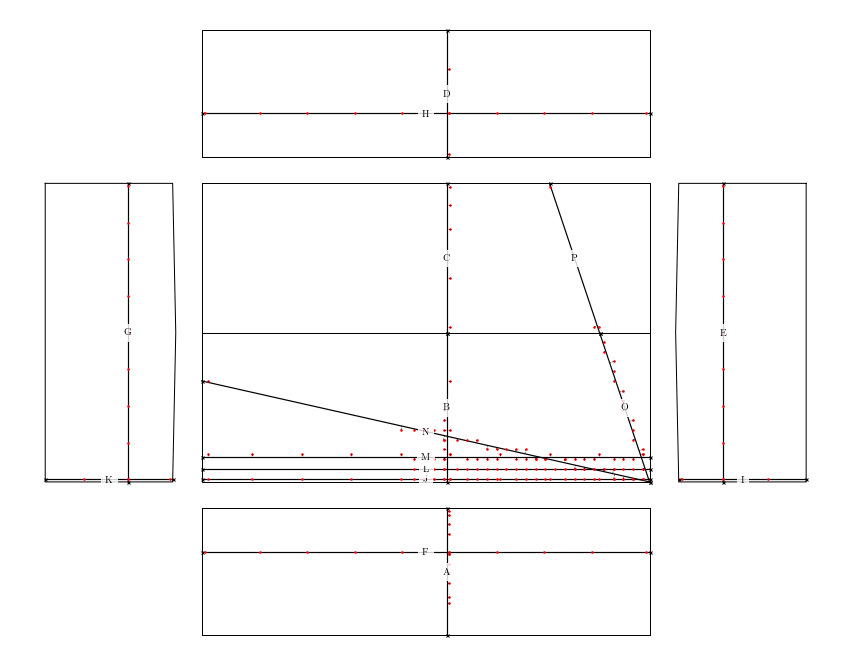

In [14]:
# fig = plt.figure(figsize=[10,8])
fig = plt.figure(figsize=[15,12])
ax = fig.add_subplot()

bldg.plotEdges(ax=ax,showName=False)
# bldg.plotZones(ax=ax)
# bldg.plotTaps(ax=ax)
# bldg.plotTribs(ax=ax)
# bldg.plotPanels(ax=ax,aIdx=2)

linesABCD_WT.plot(ax=ax)
linesEFGH_WT.plot(ax=ax)
linesIJK_WT.plot(ax=ax)
linesL_WT.plot(ax=ax)
linesM_WT.plot(ax=ax)
linesN_WT.plot(ax=ax)
linesOP_WT.plot(ax=ax)

ax.axis('equal')
ax.axis('off')
plt.show()

if saveFigs:
    # fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')
    fig.savefig(figDir+"tapLayout_withLines.svg",format='svg',dpi=1200, bbox_inches='tight')



In [15]:
print(bldg.tapIdx[50:60])
print(bldg.tapNo[50:60])

[204, 205, 206, 207, 208, 50, 51, 52, 53, 54]
[1313, 1314, 1315, 1316, 1401, 403, 404, 405, 406, 407]


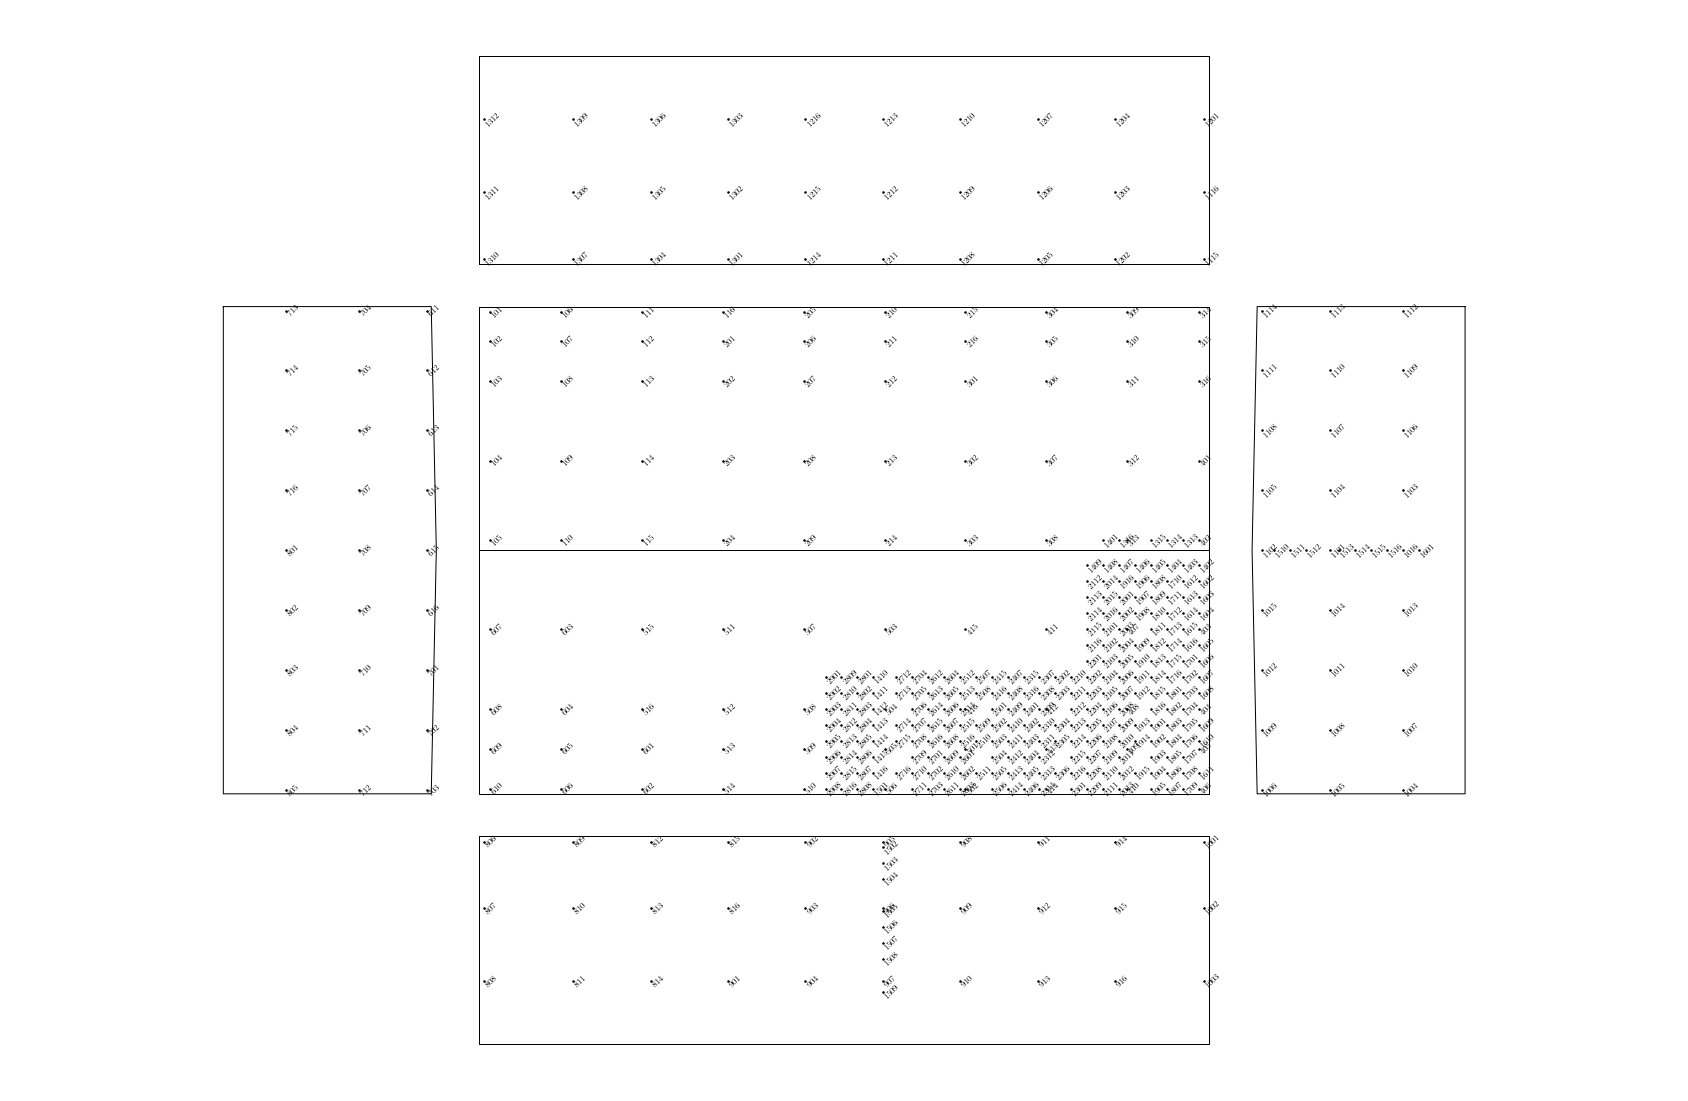

In [16]:
# tap layout
fig = plt.figure(figsize=[30,20])
ax = fig.add_subplot()

bldg.plotEdges(ax=ax,showName=False)
bldg.plotTaps(ax=ax, showTapNo=True, #tapsToPlot=bldg.tapNo[:203], 
              textOffset_tapNo=[0.0,0.00], 
              kwargs_text= { 'ha': 'left','va': 'center','color': 'k','backgroundcolor': [1, 1, 1, 0.5],'fontsize': 'small','rotation': 45,
                            'bbox': dict(boxstyle="round", fc=[1, 1, 1, 0.0], ec="None", pad=0.0),}
              )
# bldg.plotTribs(ax=ax)
# bldg.plotPanels(ax=ax,aIdx=2)

ax.axis('equal')
ax.axis('off')
if saveFigs:
    fig.savefig(figDir+"tapLayout_withTapNo.svg",format='svg',dpi=1200, bbox_inches='tight')


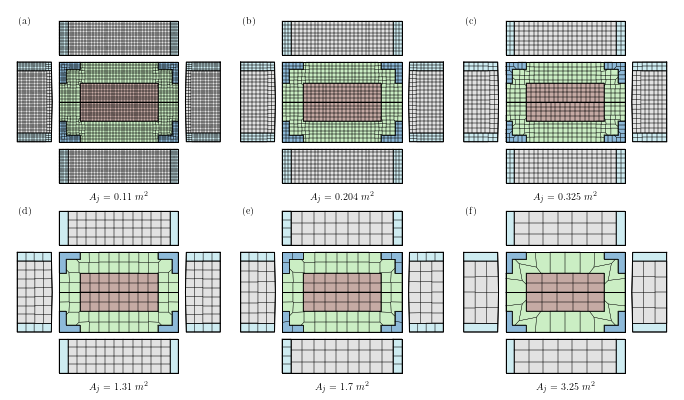

In [17]:
fig, axs = bldg.plotPanels_AllAreas(figsize=[12,7.0], nCols=3,
    areaUnit=r'$m^2$', areaFactor=areaFactor_toFSm2, areaFmt='{:2.3g}',)

if saveFigs:
    fig.savefig(figDir+"nominalPanelAreas_ASCE.svg",format='svg',dpi=300, bbox_inches='tight')

## Wind field

### LES wind field

In [18]:

lesVel_E2 = foam.readVelProfile(caseDir=caseDict['profile']['dir'], probeName=caseDict['profile']['probeName'],H=H, readFromNPY_file=True, writeToFile=True, 
                                kwargs_profile={'workSect_zLim':[0, 0.5],  'lScl':lScl, 'nSpectAvg':16})
lesVel_E2.name = "LES$(z_0=0.01m)$"
lesVel_E2.SpectH.name = lesVel_E2.name

lesVel_E2.kwargs_z0_fit_Iu = {'fitTo':'Iu', # 'Iu' or 'U'
                            'uStar_init':1.0, 
                            'z0_init':0.001, 
                            'kwargs_z0Fit':{'z0i':[1e-10,1.0]}}
_ = lesVel_E2.fit_z0(debugMode=False, )

# lesVel_E3 = foam.processVelProfile(caseDir=dir_lesE3_00, probeName='probes.V1',H=H, trimTimeSegs=[[0,1.0]])
# lesVel_E3.name = "LES(z_0=0.087m)"

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.ed.t5.r2.s2
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.ed.t5.r2.s2/postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Fitted z0 = 0.016m @FS


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:773: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)


### Wind tunnel

Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.0083 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.000928 m$). Skipping velocity statistics calculation.
Fitted z0 = 0.0081m @FS
0.00016113281448388675


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3164: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


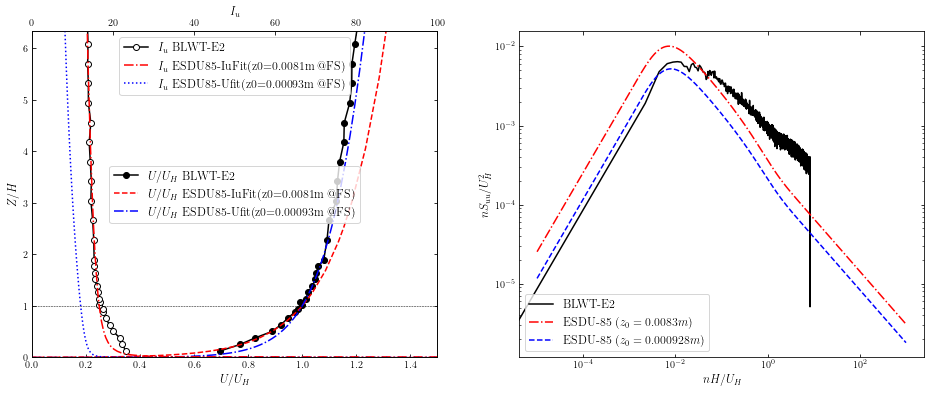

In [19]:
keepTH = True

temp = h5py.File(dir_wtVl_tngE2+"tngE2Fr1_forPython.mat", 'r')
wtVel_E2 = wind.profile(name="BLWT-E2", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, 
                        workSect_zLim=[0, 0.5], lScl=lScl,
                        keepTH=keepTH)
wtVel_E2.kwargs_z0_fit = {'fitTo':'Iu', # 'Iu' or 'U'
                        'uStar_init':1.0, 
                        'z0_init':0.001, 
                        'kwargs_z0Fit':{'z0i':[1e-10,1.0]}}
wtVel_E2.fit_z0(debugMode=True, )
print(wtVel_E2.z0_Iu)



# temp = h5py.File(dir_wtVl_tngE3+"tngE3Fr1_forPython.mat", 'r')
# wtVel_E3 = wind.profile(name="BLWT-E3", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, keepTH=keepTH)


In [20]:
vel = wind.Profiles([wtVel_E2, lesVel_E2,])

wtVel_E2_es74 = wtVel_E2.copy()
_ = wtVel_E2_es74.fit_z0(debugMode=False, ESDUversion='ESDU74')

# esdu74_E2 = wind.ESDU74(z0=wtVel_E2_es74.z0_Iu/wtVel_E2_es74.lScl, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
# esdu85_E2 = wind.ESDU85(z0=wtVel_E2.z0_Iu/wtVel_E2.lScl, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU85(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))


Message from ESDU74: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU74: Functionality for uncertainty bounds is not implemented yet.
Fitted z0 = 0.0049m @FS
Message from ESDU74: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:773: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)


## Surface pressure, $C_p$

In [21]:
peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

### Load CFD Cp

In [83]:
allPres = []
nmin = 1000000000000
tCutIdx = 14000
readFromNPY_file=True
AoA_final = []
p0_profs = []
for i, aoa in enumerate(caseDict['AoAs']):
    p,probes,time = foam.readSurfacePressure(caseDir=caseDict[aoa]['dir'], probeName=caseDict[aoa]['probeName'], trimTimeSegs=[[0,1.0]],
                                             readFromNPY_file=readFromNPY_file, writeToFile=True)
    p0,probes_0,time_0  = foam.readSurfacePressure(caseDir=caseDict[aoa]['dir'], probeName=caseDict[aoa]['p0_probeName'], trimTimeSegs=[[0,1.0]],
                                                   readFromNPY_file=readFromNPY_file, writeToFile=True)

    if p.shape[1] >= tCutIdx:
        # get the indices of common time steps between p0 and p. Don't apply tCutIdx here
        idx_p0 = np.where(np.isin(np.round(time_0,5), np.round(time,5)))[0]
        idx_p = np.where(np.isin(np.round(time,5), np.round(time_0,5)))[0]
        print(f"Shape of p0: {p0.shape}")
        print(f"Shape of p: {p.shape}")

        p = p[:, idx_p]
        p0 = p0[:, idx_p0]

        allPres.append(p - p0[-10, :])
        AoA_final.append(aoa)
        print(p.shape)
        nmin = min(nmin, p.shape[1])
        # p0_profs.append(p0_prof)

print(f"Minimum number of time steps: {nmin}")
for i in range(len(allPres)):
    print(f"Shape of allPres[{i}]: {allPres[i].shape}")
    allPres[i] = allPres[i][:, :nmin]

allPressure = np.array(allPres)

print(allPressure.shape)

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1/postProcessing/probes_WTtaps
  >> Reading probe data ...


           Reading p from: D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1/postProcessing/probes_WTtaps/0/p
                456 probes with 1122 time steps (0.0 to 0.5605)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (1122, 456)
           Reading p from: D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1/postProcessing/probes_WTtaps/0.56/p
                456 probes with 870 time steps (0.56 to 0.9945)
                No. of overlapping time steps with previously read data: 2
                Shape of data: (870, 456)
           Reading p from: D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1/postProcessing/probes_WTtaps/0.99/p
                456 probes with 1133 time steps (0.99 to 1.556)
                No. of overlapping time steps with previously read data: 10
                Shape of data: (1133, 456)
           Reading p f

In [84]:
# casename = 'tngE2.00d.m1.v1'
# pres, pts, time_p, = foam.readSurfacePressure(caseDir=les_dir+casename, probeName='probes_WTtaps', )
# pres = np.expand_dims(pres.T, axis=0)
# print(pres.shape)
dt = np.diff(time).mean()
# add one dimension as a first dimension of pres


LES_Cp = wind.bldgCp(
                    bldgName=bldg.name,
                    # name=bldg.name + 'LES',
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName='LES',
                    refProfile=lesVel_E2,
                    samplingFreq=1/dt,
                    Uref_input=lesVel_E2.Uh,
                    Uref_FS=25.0,
                    AoA=AoA_final, #caseDict['AoAs'],
                    CpOfT=None,
                    notes_Cp='---',
                    reReferenceCpToH=False,
                    pOfT=allPressure,
                    # p0ofT=p0_prof.pOfT[:nmin,-10],
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                    keepTH=True,
                    )

_ = LES_Cp.RemoveBadTaps(badTaps=badTaps, )

Refreshing LES...
Verifying data ...
Computing Cp time history ...
Uref = [12.55060702 12.55060702 12.55060702 12.55060702 12.55060702 12.55060702
 12.55060702 12.55060702 12.55060702 12.55060702 12.55060702]
Shape of self.pOfT = (11, 456, 116001)
Shape of p0ofT = ()
Shape of pOfT = (11, 456, 116001)
Shape of self.fluidDensity = ()
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing LES.

Already removed taps: [1807, 2609]
Removing taps: [1807, 2609]
Tap 1807 has already been removed. Skipping it ...
Tap 2609 has already been removed. Skipping it ...


In [85]:
# LES_Cp.faces=bldg.copy().faces
# print(LES_Cp.RemovedBadTaps)

# print(badTaps)
# removedTaps = LES_Cp.RemoveBadTaps(badTaps=badTaps, onlyFromData=True)

# print(LES_Cp.tapIdxOf(1807))

# # print the dictionary of removed taps
# print(json.dumps(LES_Cp.RemovedBadTaps, indent=4, separators=(',', ':')))
# print(LES_Cp.RemovedBadTaps)

# print(np.shape(LES_Cp.tapNo))
# print(LES_Cp.RemovedBadTaps)

In [86]:
kwargs_bldgDef = {
    'bldgName':bldg.name,
    'faces':bldg.faces,
    'H':H,'D':D,'B':B,'roofSlope':roofSlope,'lScl':lScl,
    'AoA_zero_deg_basisVector':bldg.AoA_zero_deg_basisVector,
    'AoA_rotation_direction':bldg.AoA_rotation_direction,
    'caseName':'LES',
    'refProfile':lesVel_E2,
    'samplingFreq':1/dt,
    'Uref_input':lesVel_E2.Uh,
    'Uref_FS':25.0,
    'AoA':AoA_final, #caseDict['AoAs'],
    'notes_Cp':'---',
    'reReferenceCpToH':False,
    'CpStats':None,
    'peakSpecs':peakSpecs,
    'CpStats_fields':['mean','std','peak','skewness','kurtosis'],
    'computeAreaAveragedCpStats':False,
    }

LES_Cp_cum = wind.BldgCp_cummulative(mainBldg=LES_Cp, N_steps=100, kwargs_bldgDef=kwargs_bldgDef)

***********************************************************************************************
Creating 100 sub-buildings with an increment of 1160 time steps.
-----------------------------------------------------------------------------------------------
Refreshing LES...
Verifying data ...
Computing Cp statistics ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:6487: UserWarning: Overwriting 'bldgName' in kwargs_bldgDef
  warnings.warn(f"Overwriting 'bldgName' in kwargs_bldgDef")


Done refreshing LES.

    Created sub-building 1 of 100
        T = 0.58 s
-----------------------------------------------------------------------------------------------
Refreshing LES...
Verifying data ...
Computing Cp statistics ...
Done refreshing LES.

    Created sub-building 2 of 100
        T = 1.16 s
-----------------------------------------------------------------------------------------------
Refreshing LES...
Verifying data ...
Computing Cp statistics ...
Done refreshing LES.

    Created sub-building 3 of 100
        T = 1.74 s
-----------------------------------------------------------------------------------------------
Refreshing LES...
Verifying data ...
Computing Cp statistics ...
Done refreshing LES.

    Created sub-building 4 of 100
        T = 2.32 s
-----------------------------------------------------------------------------------------------
Refreshing LES...
Verifying data ...
Computing Cp statistics ...
Done refreshing LES.

    Created sub-building 5 of 100


In [87]:
# _ = LES_Cp.plotCpTimeHistories(#tapsToPlot=[801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816], 
#                                AoA=70)
# LES_Cp_cum.CalculateInnerStats()

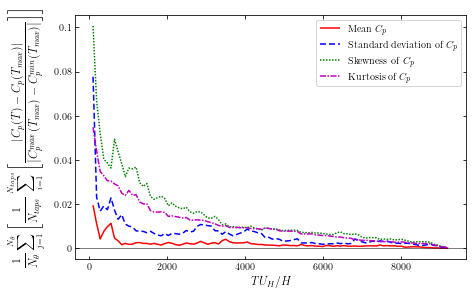

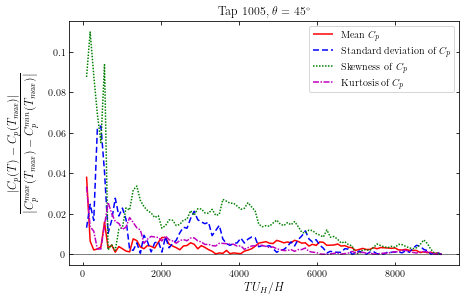

In [88]:
cols = ['r','b','g','m','tab:purple','tab:brown','tab:pink','tab:olive','tab:cyan','tab:gray','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','tab:gray','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','tab:gray','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','tab:gray','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','tab:gray','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','tab:gray','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','tab:gray','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan',]
ls = ['-','--','-.',':']
dashes = [[1,0],[4,2],[1,1],[4,1,1,1],[4,2,1,2],[4,2,1,2,1,2],[4,2,1,2,1,2,1,2],[4,2,1,2,1,2,1,2,1,2],[4,2,1,2,1,2,1,2,1,2,1,2],[4,2,1,2,1,2,1,2,1,2,1,2,1,2],]
# ls = ['-','-','-','-']
# fields = ['mean','std','peakMin','peakMax',]
fields = ['mean','std','skewness','kurtosis']
fields2 = ['peakMin','peakMax',]

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10,4])
fig = plt.figure(figsize=[7,4.5])
ax = fig.add_subplot()

# ax = axs[0]
tapIdx = LES_Cp.tapIdxOf(406)
for n, s in enumerate(fields):
    tapIdxs = LES_Cp.tapIdx
    # for i in range(456): #range(231,233):
    #     for j in range(0,3):
    #         ax.plot(LES_Cp_cum.T, stat[:,j,i], color='gray',alpha=0.5, )#label= LES_Cp.tapNo[tapIdxs[i]])


    # ax.plot(LES_Cp_cum.T_star_AoAavg, LES_Cp_cum.CpStats_NormRange_AoAavg[s][:,tapIdx], label=wind.fullName(s,False), alpha=1, lw=1.5,color=cols[n],ls=ls[n])
    stat = LES_Cp_cum.CpStats_NormRange_AoATapAvg[s]
    ax.plot(LES_Cp_cum.T_star_AoAavg, stat, label=wind.fullName(s,False), lw=1.5, color=cols[n],dashes=dashes[n])

    # stat = LES_Cp_cum.CpStats_NormRange_TapAvg[s]
    # for j,aoa in enumerate(LES_Cp.AoA):
    #     ax.plot(LES_Cp_cum.T_star_AoAavg, stat[:,j], label=f'${aoa}^\circ$', lw=0.5, alpha=0.6,ls=ls[n], color=cols[j])
        
    
ax.axhline(y=0.0, color='k', linestyle='-',lw=0.5)
ax.set_xlabel(wind.mathName('T*'))
# increase the gap from the plot to the y-axis label
ax.set_ylabel(LES_Cp_cum.CpStats_NormRange_AoATapAvg_eqn, labelpad=10.0)
ax.legend()#ncol=len(fields))
# ax.set_ylim([-0.05,1.0])
# ax.text(0.03, 0.98, '(a)', transform=ax.transAxes, fontsize=14, va='top', ha='left')
wind.formatAxis(ax, gridMajor=False)


# ax = axs[1]
# for n, s in enumerate(fields2):
#     tapIdxs = LES_Cp.tapIdx
#     # for i in range(456): #range(231,233):
#     #     for j in range(0,3):
#     #         ax.plot(LES_Cp_cum.T, stat[:,j,i], color='gray',alpha=0.5, )#label= LES_Cp.tapNo[tapIdxs[i]])

#     stat = LES_Cp_cum.CpStats_NormRange_AoATapAvg[s]
#     ax.plot(LES_Cp_cum.T_star_AoAavg, stat, label=wind.fullName(s,True), lw=1.5,color='k',ls=ls[n])

#     stat = LES_Cp_cum.CpStats_NormRange_TapAvg[s]
#     for j,aoa in enumerate(LES_Cp.AoA):
#         ax.plot(LES_Cp_cum.T_star_AoAavg, stat[:,j], label=f'${aoa}^\circ$', lw=0.5, alpha=0.6,ls=ls[n], color=cols[j])
    
# ax.axhline(y=0.0, color='k', linestyle='-',lw=0.5)
# ax.set_xlabel(wind.mathName('T*'))
# # ax.set_ylabel(LES_Cp_cum.CpStats_NormRange_AoATapAvg_eqn)
# ax.legend(ncol=len(fields2))
# # ax.set_ylim([-0.2,5.0])
# ax.text(0.03, 0.98, '(b)', transform=ax.transAxes, fontsize=14, va='top', ha='left')
# wind.formatAxis(ax, gridMajor=False)

plt.show()

if saveFigs:
    # fig.savefig(figDir+"CpStats_NormTmax_AoATapAvg.svg",format='svg',dpi=1200, bbox_inches='tight')
    fig.savefig(figDir+"CpStats_NormTmax_AoATapAvg_simple.svg",format='svg',dpi=1200, bbox_inches='tight')
    fig.savefig(figDir+"CpStats_NormTmax_AoATapAvg_simple.pdf",format='pdf',dpi=1200, bbox_inches='tight')
        
    
    
fig = plt.figure(figsize=[7,4.5])
ax = fig.add_subplot()

tapNo, AoA = 1005, 45
tapIdx = LES_Cp.tapIdxOf(tapNo)
aoaIdx = LES_Cp.AoA.index(AoA)
for n, s in enumerate(fields):
    tapIdxs = LES_Cp.tapIdx
    # for i in range(456): #range(231,233):
    #     for j in range(0,3):
    #         ax.plot(LES_Cp_cum.T, stat[:,j,i], color='gray',alpha=0.5, )#label= LES_Cp.tapNo[tapIdxs[i]])


    # stat = LES_Cp_cum.CpStats_NormRange_AoAavg[s][:,tapIdx]
    stat = LES_Cp_cum.CpStats_NormRange[s][:,aoaIdx,tapIdx]
    # ax.plot(LES_Cp_cum.T_star_AoAavg, LES_Cp_cum.CpStats_NormRange_AoAavg[s][:,tapIdx], label=wind.fullName(s,False), alpha=1, lw=1.5,color=cols[n],ls=ls[n])
    ax.plot(LES_Cp_cum.T_star_AoAavg, stat, label=wind.fullName(s,False), lw=1.5, color=cols[n],dashes=dashes[n])

    # stat = LES_Cp_cum.CpStats_NormRange_TapAvg[s]
    # for j,aoa in enumerate(LES_Cp.AoA):
    #     ax.plot(LES_Cp_cum.T_star_AoAavg, stat[:,j], label=f'${aoa}^\circ$', lw=0.5, alpha=0.6,ls=ls[n], color=cols[j])
        
    
ax.axhline(y=0.0, color='k', linestyle='-',lw=0.5)
ax.set_title(f"Tap {tapNo}, $\\theta = {AoA}^\\circ$")
ax.set_xlabel(wind.mathName('T*'))
ax.set_ylabel(LES_Cp_cum.CpStats_NormRange_eqn, labelpad=10.0)
ax.legend()#ncol=len(fields))
# ax.set_ylim([-0.05,1.0])
wind.formatAxis(ax, gridMajor=False)

plt.show()

# if saveFigs:
#     # fig.savefig(figDir+"CpStats_NormTmax_AoATapAvg.svg",format='svg',dpi=1200, bbox_inches='tight')
#     fig.savefig(figDir+"CpStats_NormTmax_AoATapAvg_byTap.svg",format='svg',dpi=1200, bbox_inches='tight')
    

In [89]:
saveFigs = True

### Wind tunnel data

In [90]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 3009,
                'main_pitot_q': 3010,
                '20inch_pitot_zero': 3007,
                '20inch_pitot_q': 3008,
                'Uh_pitot_zero': 3005,
                'Uh_pitot_q': 3006,
            }

mainRefPitotChnlIdx = 2
Zpitot = 1.48
Ntaps = 456
lowpassFreq=200.0

In [91]:
# cps_OP = []
i, rID = 0, runIDs[0]
# for i, rID in enumerate(runIDs):
print(">> Processing: OP-"+rID)
cp_raw = wt.BLWTL_HFPI(
    caseDir=dir_wtCp_tngE2[i],
    userNotes=None,
    Z_MainPitot=Zpitot,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=lowpassFreq,
    Ntaps=Ntaps,
    AoAsToRead=caseDict['AoAs'],
)
winsound.Beep(1000, 1000)
print("      Loaded raw data")
print(cp_raw.description)


>> Processing: OP-p1


AttributeError: 'bldgCp' object has no attribute 'BLWTL_HFPI'

#### Arrange the raw data to match LES $T^*$ (including folding as necessary)

In [ ]:
print([f"[{a}, {b}]" for a, b in zip(cp_raw.tapNos, bldg.tapNo)])



['[101, 101]', '[102, 102]', '[103, 103]', '[104, 104]', '[105, 105]', '[106, 106]', '[107, 107]', '[108, 108]', '[109, 109]', '[110, 110]', '[111, 111]', '[112, 112]', '[113, 113]', '[114, 114]', '[115, 115]', '[116, 116]', '[201, 201]', '[202, 202]', '[203, 203]', '[204, 204]', '[205, 205]', '[206, 206]', '[207, 207]', '[208, 208]', '[209, 209]', '[210, 210]', '[211, 211]', '[212, 212]', '[213, 213]', '[214, 214]', '[215, 215]', '[216, 216]', '[301, 301]', '[302, 302]', '[303, 303]', '[304, 304]', '[305, 305]', '[306, 306]', '[307, 307]', '[308, 308]', '[309, 309]', '[310, 310]', '[311, 311]', '[312, 312]', '[313, 313]', '[314, 314]', '[315, 315]', '[316, 316]', '[401, 401]', '[402, 402]', '[403, 1313]', '[404, 1314]', '[405, 1315]', '[406, 1316]', '[407, 1401]', '[408, 403]', '[409, 404]', '[410, 405]', '[411, 406]', '[412, 407]', '[413, 408]', '[414, 409]', '[415, 410]', '[416, 411]', '[501, 412]', '[502, 413]', '[503, 414]', '[504, 415]', '[505, 416]', '[506, 501]', '[507, 502]', 

In [ ]:
tMax_WT = np.mean(LES_Cp.T_star) * H / np.mean(LES_Cp.Uref)
dt = 1/np.mean(cp_raw.sampleRate)
tMax_Idx = int(tMax_WT/dt)

N_tot = cp_raw.CpTH.shape[-1]
N_folds = 7 #int(N_tot/tMax_Idx)
tMax_Idx = int(N_tot/N_folds)
print(f" WT has {N_tot} time steps. Splitting into {N_folds} folds of {tMax_Idx} time steps or {tMax_Idx*dt} seconds each.")

# # the velocity can't be scaled directly because the test speed is different from that of the HFPI
# speedRatio = wtVel_E2.Uh / np.mean(cp_raw.Uref)
# tMax_Idx_vel = int(tMax_WT*speedRatio*wtVel_E2.samplingFreq)
# wtVel_E2.UofT = wtVel_E2.UofT[:,:tMax_Idx_vel]
# wtVel_E2.VofT = wtVel_E2.VofT[:,:tMax_Idx_vel]
# wtVel_E2.WofT = wtVel_E2.WofT[:,:tMax_Idx_vel]
# wtVel_E2.t = wtVel_E2.t[:tMax_Idx_vel]
# wtVel_E2.Refresh()


 WT has 59976 time steps. Splitting into 7 folds of 8568 time steps or 42.84 seconds each.


In [ ]:
print(cp_raw.CpTH.shape)

WT_cp = wind.bldgCp(
                bldgName=bldg.name + 'BLWT',
                faces=bldg.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg.AoA_rotation_direction,
                caseName='OP_ASCE_C&C_'+rID,
                refProfile=wtVel_E2,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                Uref_FS=25.0,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH[:,:,:tMax_Idx],
                notes_Cp=cp_raw.description,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                keepTH=True,
                )
WT_cp.RemoveBadTaps(badTaps=badTaps, onlyFromData=True, )
WT_cp.name = 'BLWT'
print(f"Shape of CpTH: {WT_cp.CpOfT.shape}")
winsound.Beep(1500, 1000)
print("      << Complete!")

WT_cp.profile.fit_z0(debugMode=False,)
# cps_OP.append(cp)

WT_cp.sampleLines = allLines.copy()
for key in WT_cp.sampleLines.keys():
    WT_cp.sampleLines[key].parentBldg = WT_cp

# del cp_raw, cp

(11, 456, 59976)
Re-scaling profile to match Uref ...
    Uref_avg = 12.471 m/s
    U_ref_prof = 7.582 m/s
    U_ratio = 1.645
    time_ratio = 0.608
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing OP_ASCE_C&C_p1.

Removing taps [1807, 2609] from the data only ...
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:773: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)


In [ ]:
print(bldg.RemovedBadTaps)

{1807: {'IndexInData': 278, 'Face': 'Roof_2', 'tapName': '', 'tapCoord': [array([0.0116944, 0.115248 ])]}, 2609: {'IndexInData': 408, 'Face': 'Roof_2', 'tapName': '', 'tapCoord': [array([0.08353731, 0.03741818])]}}


In [ ]:
cps_OP = []
for i in range(N_folds):
    cp = wind.bldgCp(
                    bldgName=bldg.name + 'BLWT-' + str(i),
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName='OP_ASCE_C&C_'+rID,
                    refProfile=wtVel_E2,
                    Zref_input=cp_raw.Z_MainPitot,
                    Uref_input=cp_raw.Uref,
                    Uref_FS=25.0,
                    samplingFreq=cp_raw.sampleRate,
                    AoA=cp_raw.AoA,
                    CpOfT=cp_raw.CpTH[:,:,i*tMax_Idx:(i+1)*tMax_Idx],
                    notes_Cp=cp_raw.description,
                    reReferenceCpToH=True,
                    pOfT=None,
                    p0ofT=None,
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                    keepTH=True,
                    )
    print(f"Shape of CpStats: {np.shape(cp.CpStats['mean'])}")
    cp.RemoveBadTaps(badTaps=badTaps, onlyFromData=True, )
    cp.CpOfT = None
    print(f"Shape of CpStats: {np.shape(cp.CpStats['mean'])}")
    cp.name = 'BLWT'
    # print(f"Shape of CpTH: {cp.CpOfT.shape}")
    winsound.Beep(1000, 300)
    print("      << Complete!")

    cp.profile.fit_z0(debugMode=False,)
    cps_OP.append(cp)
    print("------------------------------------------")
    
WT_cp_all = wind.BldgCps(cps_OP)#.asBldgObj()
WT_cp_avg = WT_cp_all.asBldgObj()
winsound.Beep(1000, 1500)

for wtcp in WT_cp_all.memberBldgs:
    wtcp.sampleLines = allLines.copy()
    for key in wtcp.sampleLines.keys():
        wtcp.sampleLines[key].parentBldg = wtcp
        
WT_cp_avg.sampleLines = allLines.copy()
for key in WT_cp_avg.sampleLines.keys():
    WT_cp_avg.sampleLines[key].parentBldg = WT_cp_avg

del cps_OP

Re-scaling profile to match Uref ...
    Uref_avg = 12.471 m/s
    U_ref_prof = 7.582 m/s
    U_ratio = 1.645
    time_ratio = 0.608
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing OP_ASCE_C&C_p1.

Shape of CpStats: (11, 456)
Removing taps [1807, 2609] from the data only ...
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Com

In [ ]:
print(WT_cp.T_star)
print(LES_Cp.T_star)
print(np.mean(WT_cp.T_star)/np.mean(LES_Cp.T_star))
print(np.shape(WT_cp_avg.CpStats['mean']))
print(tMax_Idx)

[6793.70570005 6788.10683388 6765.74605723 6755.97500055 6745.37699917
 6749.40391694 6755.40006612 6758.42609718 6749.46301026 6740.68715148
 6744.2126695 ]
[6398.58488872 6398.58488872 6398.58488872 6398.58488872 6398.58488872
 6398.58488872 6398.58488872 6398.58488872 6398.58488872 6398.58488872
 6398.58488872]
1.0562918462778974
(11, 454)
8568


## validator

In [ ]:
validator = wind.validator(target=WT_cp_avg, 
                        # model=lesCp_E2_old, 
                        model=LES_Cp,
                        correctForIuDifference=False)

validator_2 = wind.validator(target=WT_cp_avg,
                        # model=lesCp_E2_old, 
                        # errorTypes_CpAavg=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'],
                        # errorTypes_CpStats=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'],
                        # errorTypes_velStats=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'],
                        model=LES_Cp,
                        correctForIuDifference=True)

# print(json.dumps(validator.error_CpStats['peakMin'], indent=4))
# print(validator.error_CpStats.keys())



D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:5960: RuntimeWarning: invalid value encountered in log10
  tmp1['orderOfMagnitude'][key] = np.log10(mp_i/tp_i)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:5989: UserWarning: The target and model faces seem to be referring to different 'faces' objects. This may result in failure to calculate CpStats error or incorrect values. Please check and make sure that all the face geometries, tap layouts, and other details are the same (except for the Cp data) between the target and model. The computation will continue but the results may be incorrect.
  warnings.warn(f"The target and model faces seem to be referring to different 'faces' objects. This may result in failure to calculate CpStats error or incorrect values. Please check and make sure that all the face geometries, tap layouts, and other details are the same (except for

In [ ]:
print(validator_2.IuFctr)
LES_Cp_corrected = LES_Cp.copy()
LES_Cp_corrected.name = 'LES-expCorr'
LES_Cp_corrected.scaleCpStats(validator_2.IuFctr)


0.8945886563294978


In [ ]:
cps = wind.BldgCps([WT_cp, LES_Cp])
profs = wind.Profiles([WT_cp.profile, LES_Cp.profile])

linesABCD_WT.parentBldg = WT_cp
linesABCD_LES.parentBldg = LES_Cp_corrected
linesEFGH_WT.parentBldg = WT_cp
linesEFGH_LES.parentBldg = LES_Cp_corrected
linesIJK_WT.parentBldg = WT_cp
linesIJK_LES.parentBldg = LES_Cp
linesL_WT.parentBldg = WT_cp
linesL_LES.parentBldg = LES_Cp
linesM_WT.parentBldg = WT_cp
linesM_LES.parentBldg = LES_Cp
linesN_WT.parentBldg = WT_cp
linesN_LES.parentBldg = LES_Cp
linesOP_WT.parentBldg = WT_cp
linesOP_LES.parentBldg = LES_Cp

Number of member bldgs: 2


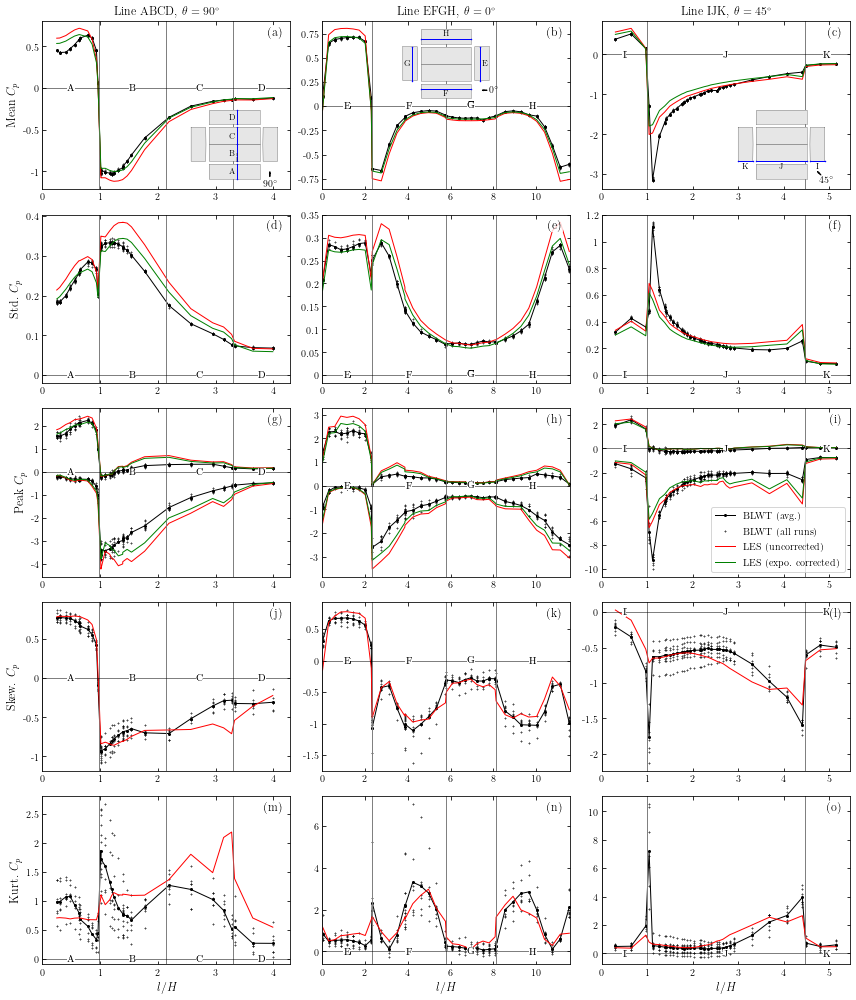

In [ ]:
showLES_corr = True
showLES_uncorr = True
ms = 2
lw = 1.0
kwargs_plt_WT={'ls':'', 'marker':'+', 'color':'k', 'ms':ms, 'lw':0.5, 'alpha':0.7}
kwargs_plt_WTavg={'ls':'-', 'marker':'o', 'color':'k', 'ms':ms, 'lw':lw}
kwargs_plt_LES={'ls':'-', 'marker':'', 'color':'r', 'ms':5, 'lw':lw}
kwargs_plt_LEScorr={'ls':'-', 'marker':'', 'color':'g', 'ms':5, 'lw':lw}

fig, axs = plt.subplots(5, 3, figsize=[12,14.0],)

AoA = 90
ax = axs[0,0]
label = "BLWT (avg.)"
linesABCD_WT.parentBldg = WT_cp_avg
linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesABCD_WT.parentBldg = wt
    linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='mean', label=label, showXLabel=False, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesABCD_LES.parentBldg = LES_Cp
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesABCD_LES.parentBldg = LES_Cp_corrected
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesABCD_LES.length_Norm])
ax.set_title(f"Line ABCD, $\\theta={AoA}^\circ$")
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax = axs[1,0]
label = "BLWT (avg.)"
linesABCD_WT.parentBldg = WT_cp_avg
linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesABCD_WT.parentBldg = wt
    linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesABCD_LES.parentBldg = LES_Cp
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesABCD_LES.parentBldg = LES_Cp_corrected
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesABCD_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax = axs[2,0]
label = "BLWT (avg.)"
linesABCD_WT.parentBldg = WT_cp_avg
linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, label='', kwargs_plt=kwargs_plt_WTavg)
linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, label=label, showLineSegmentNames=False, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesABCD_WT.parentBldg = wt
    linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMax', yLabel=wind.fullName('peak',abbreviate=True), showXLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
    linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, label=label, showLineSegmentNames=False, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesABCD_LES.parentBldg = LES_Cp
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesABCD_LES.parentBldg = LES_Cp_corrected
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesABCD_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax = axs[3,0]
label = "BLWT (avg.)"
linesABCD_WT.parentBldg = WT_cp_avg
linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesABCD_WT.parentBldg = wt
    linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesABCD_LES.parentBldg = LES_Cp
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
# if showLES_corr:
#     linesABCD_LES.parentBldg = LES_Cp_corrected
#     linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesABCD_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)


ax = axs[4,0]
label = "BLWT (avg.)"
linesABCD_WT.parentBldg = WT_cp_avg
linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=True, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesABCD_WT.parentBldg = wt
    linesABCD_WT.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesABCD_LES.parentBldg = LES_Cp
    linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
# if showLES_corr:
#     linesABCD_LES.parentBldg = LES_Cp_corrected
#     linesABCD_LES.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesABCD_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)



AoA = 0
ax = axs[0,1]
label = "BLWT (avg.)"
linesEFGH_WT.parentBldg = WT_cp_avg
linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesEFGH_WT.parentBldg = wt
    linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesEFGH_LES.parentBldg = LES_Cp
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesEFGH_LES.parentBldg = LES_Cp_corrected
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesEFGH_LES.length_Norm])
ax.set_title(f"Line EFGH, $\\theta={AoA}^\circ$")
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax = axs[1,1]
label = "BLWT (avg.)"
linesEFGH_WT.parentBldg = WT_cp_avg
linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesEFGH_WT.parentBldg = wt
    linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesEFGH_LES.parentBldg = LES_Cp
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesEFGH_LES.parentBldg = LES_Cp_corrected
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesEFGH_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax = axs[2,1]
label = "BLWT (avg.)"
linesEFGH_WT.parentBldg = WT_cp_avg
linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, label='', kwargs_plt=kwargs_plt_WTavg)
linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, label=label, showLineSegmentNames=False, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesEFGH_WT.parentBldg = wt
    linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMax', label=label, showXLabel=False, showYLabel=False, kwargs_plt=kwargs_plt_WT)
    linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMin', label=label, showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesEFGH_LES.parentBldg = LES_Cp
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesEFGH_LES.parentBldg = LES_Cp_corrected
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesEFGH_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)


ax = axs[3,1]
label = "BLWT (avg.)"
linesEFGH_WT.parentBldg = WT_cp_avg
linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesEFGH_WT.parentBldg = wt
    linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesEFGH_LES.parentBldg = LES_Cp
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
# if showLES_corr:
#     linesEFGH_LES.parentBldg = LES_Cp_corrected
#     linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesEFGH_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax = axs[4,1]
label = "BLWT (avg.)"
linesEFGH_WT.parentBldg = WT_cp_avg
linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=True, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesEFGH_WT.parentBldg = wt
    linesEFGH_WT.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesEFGH_LES.parentBldg = LES_Cp
    linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
# if showLES_corr:
#     linesEFGH_LES.parentBldg = LES_Cp_corrected
#     linesEFGH_LES.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesEFGH_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)


AoA = 45
ax = axs[0,2]
linesIJK_WT.parentBldg = WT_cp_avg
linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesIJK_WT.parentBldg = wt
    linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesIJK_LES.parentBldg = LES_Cp
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesIJK_LES.parentBldg = LES_Cp_corrected
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='mean', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesIJK_LES.length_Norm])
ax.set_title(f"Line IJK, $\\theta={AoA}^\circ$")
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax = axs[1,2]
linesIJK_WT.parentBldg = WT_cp_avg
linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesIJK_WT.parentBldg = wt
    linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesIJK_LES.parentBldg = LES_Cp
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesIJK_LES.parentBldg = LES_Cp_corrected
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='std', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesIJK_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax = axs[2,2]
label = "BLWT (avg.)"
linesIJK_WT.parentBldg = WT_cp_avg
linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, label='', kwargs_plt=kwargs_plt_WTavg)
linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, label=label, showLineSegmentNames=False, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT (all runs)" if i==0 else ''
    linesIJK_WT.parentBldg = wt
    linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, label='', kwargs_plt=kwargs_plt_WT)
    linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, label=label, showLineSegmentNames=False, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesIJK_LES.parentBldg = LES_Cp
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, label='', showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, label='LES (uncorrected)', showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
if showLES_corr:
    linesIJK_LES.parentBldg = LES_Cp_corrected
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMax', showXLabel=False, showYLabel=False, label='', showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='peakMin', showXLabel=False, showYLabel=False, label='LES (expo. corrected)', showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesIJK_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)

ax.legend(loc='lower right', )
# # place the legend at the bottom of the main figure (not the subplot)
# ax.legend(loc='bottom left', bbox_to_anchor=(0.0, -0.8), ncol=4)


ax = axs[3,2]
linesIJK_WT.parentBldg = WT_cp_avg
linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesIJK_WT.parentBldg = wt
    linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesIJK_LES.parentBldg = LES_Cp
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
# if showLES_corr:
#     linesIJK_LES.parentBldg = LES_Cp_corrected
#     linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesIJK_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)


ax = axs[4,2]
linesIJK_WT.parentBldg = WT_cp_avg
linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=True, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WTavg)
for i, wt in enumerate(WT_cp_all.memberBldgs):
    label = "BLWT" if i==0 else ''
    linesIJK_WT.parentBldg = wt
    linesIJK_WT.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=False, showYLabel=False, label=label, kwargs_plt=kwargs_plt_WT)
if showLES_uncorr:
    linesIJK_LES.parentBldg = LES_Cp
    linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='kurtosis', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LES)
# if showLES_corr:
#     linesIJK_LES.parentBldg = LES_Cp_corrected
#     linesIJK_LES.plotCpStats(ax=ax, AoA=AoA, field='skewness', showXLabel=False, showYLabel=False, showLineSegmentNames=False, kwargs_plt=kwargs_plt_LEScorr)
ax.axhline(y=0.0, ls='-', color='k', lw=0.5)
ax.set_xlim([0, linesIJK_LES.length_Norm])
wind.formatAxis(ax=ax, gridMajor=False, gridMinor=False)


# create an inset axes object in axs[1,2] with independent axes values
kwargs_line = {'txtDistFromLine':0.027,
               'kwargs_Edge':{'color':'b', 'lw':1.0, 'ls':'-', 'marker':'.', 'markersize':1},
               'kwargs_Name':{'ha':'center', 'va':'center', 'color':'k', 'fontsize':8, 'bbox':{'facecolor':'w', 'alpha':0.0, 'pad':0.15, 'edgecolor':'none'}}}
kwargs_taps={'kwargs_dots':{'color':'r', 'lw':0.5, 'ls':'None', 'marker':'', 'markersize':1},
            'kwargs_text':{'ha':'left', 'va':'top', 'color':'k', 'backgroundcolor':[1,1,1,0.0], 'fontsize':'small', 'rotation':45},}
kwargs_Fill={'facecolor':[0.9,0.9,0.9], 'edgecolor':'None', 'lw':0.5, 'ls':'-'}
kwargs_Edge = { 'color': [0.5,0.5,0.5],'lw': 0.5,'ls': '-' }


ax2 = axs[0,0].inset_axes([0.55, 0.04, 0.45, 0.45])
bldg.plotEdges(ax=ax2,showName=False, fill=True, kwargs_Edge=kwargs_Edge, kwargs_Fill=kwargs_Fill)
bldg.plotAoA_symbol(ax=ax2, AoA=90, location='lower right', drawDicorations=False, textOffsetFactor=4, size=0.8)
linesABCD_LES.plot(ax=ax2, kwargs_line=kwargs_line, kwargs_taps=kwargs_taps)
ax2.axis('equal')
ax2.axis('off')

ax2 = axs[0,1].inset_axes([0.275, 0.52, 0.45, 0.45])
bldg.plotEdges(ax=ax2,showName=False, fill=True, kwargs_Edge=kwargs_Edge, kwargs_Fill=kwargs_Fill)
bldg.plotAoA_symbol(ax=ax2, AoA=0, location='lower right', drawDicorations=False, textOffsetFactor=4, size=0.8)
linesEFGH_LES.plot(ax=ax2, kwargs_line=kwargs_line, kwargs_taps=kwargs_taps)
ax2.axis('equal')
ax2.axis('off')

ax2  = axs[0,2].inset_axes([0.5, 0.04, 0.45, 0.45])
bldg.plotEdges(ax=ax2,showName=False, fill=True, kwargs_Edge=kwargs_Edge, kwargs_Fill=kwargs_Fill)
bldg.plotAoA_symbol(ax=ax2, AoA=45, location='lower right', drawDicorations=False, textOffsetFactor=4, size=0.8)
linesIJK_WT.plot(ax=ax2, kwargs_line=kwargs_line, kwargs_taps=kwargs_taps)
ax2.axis('equal')
ax2.axis('off')


kwargs = {'xycoords':'axes fraction', 'ha':'right', 'va':'top', 'color':'k', 'fontsize':'large', 
          'bbox':{'facecolor':'w', 'alpha':0.8, 'pad':0.5, 'edgecolor':'none'}}
xy = (0.97, 0.97)
axs[0,0].annotate('(a)', xy=xy, **kwargs)
axs[0,1].annotate('(b)', xy=xy, **kwargs)
axs[0,2].annotate('(c)', xy=xy, **kwargs)
axs[1,0].annotate('(d)', xy=xy, **kwargs)
axs[1,1].annotate('(e)', xy=xy, **kwargs)
axs[1,2].annotate('(f)', xy=xy, **kwargs)
axs[2,0].annotate('(g)', xy=xy, **kwargs)
axs[2,1].annotate('(h)', xy=xy, **kwargs)
axs[2,2].annotate('(i)', xy=xy, **kwargs)
axs[3,0].annotate('(j)', xy=xy, **kwargs)
axs[3,1].annotate('(k)', xy=xy, **kwargs)
axs[3,2].annotate('(l)', xy=xy, **kwargs)
axs[4,0].annotate('(m)', xy=xy, **kwargs)
axs[4,1].annotate('(n)', xy=xy, **kwargs)
axs[4,2].annotate('(o)', xy=xy, **kwargs)

plt.tight_layout()

plt.show()

if saveFigs:
    fig.savefig(figDir+"CpStats_overline_4ppt.svg",format='svg',dpi=300, bbox_inches='tight')
    # fig.savefig(figDir+"CpStats_overline.svg",format='svg',dpi=300, bbox_inches='tight')
    # fig.savefig(figDir+"CpStats_overline.pdf",format='pdf',dpi=300, bbox_inches='tight')

In [ ]:
# read a json file
file = r"C:\Users\Tsinu\Downloads\alljobs_nar.json"

data = json.load(open(file))



In [ ]:
# for i in range(750):
#     print(data['jobs'][i]['name'])

print(len(data['jobs']))

i=60
print(data['jobs'][i].keys())
print(data['jobs'][i]['script'])
print(data['jobs'][i]['time']['elapsed']/3600)
print((data['jobs'][i]['time']['start']-data['jobs'][i]['time']['submission'])/3600)

2120
dict_keys(['account', 'comment', 'allocation_nodes', 'array', 'association', 'block', 'cluster', 'constraints', 'container', 'derived_exit_code', 'time', 'exit_code', 'extra', 'failed_node', 'flags', 'group', 'het', 'job_id', 'name', 'licenses', 'mcs', 'nodes', 'partition', 'hold', 'priority', 'qos', 'required', 'kill_request_user', 'reservation', 'script', 'state', 'steps', 'submit_line', 'tres', 'used_gres', 'user', 'wckey', 'working_directory'])

0.5427777777777778
7.636666666666667


# Plots

No velocity time history found for ESDU-74 ($z_0=0.01 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.01 m$). Skipping velocity statistics calculation.
Message from Profiles.plotProfile_basic2(): Future feature notice: a table of normalizers like H, Uref, etc. next to the legend.
          Location: D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py
          Function: plotProfile_basic2
          Line number: 5157


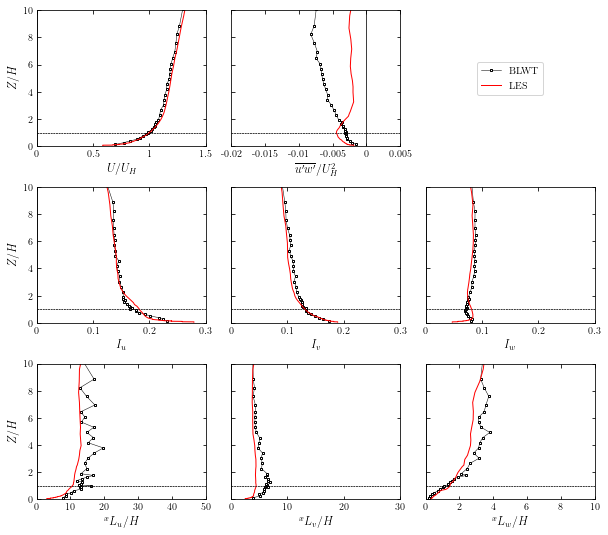

In [ ]:
WT_cp.profile.name = 'BLWT'
LES_Cp.profile.name = 'LES'
es74 = esdu74_E2.toProfileObj()
es74.name = f'ESDU-74 ($z_0={es74.z0_Iu:.2g}m$)'
es74.SpectH.name = es74.name

es85 = esdu85_E2.toProfileObj()
es85.name = f'ESDU-85 ($z_0={es85.z0_Iu:.2g}m$)'
es85.SpectH.name = es85.name

# profs = wind.Profiles([es74, es85, WT_cp.profile, LES_Cp.profile]) #, es74, es85])
profs = wind.Profiles([WT_cp.profile, LES_Cp.profile]) #, es74, es85])

fig, axs = profs.plotProfile_basic2(figsize=[10,9], hspace=0.3, wspace=0.15, sharey=True,
            yLimits=[0,10], showSubPlotLabels=False, #subPlotLabels={'U':'(a)', 'uw':'(b)', 'Iu':'(c)', 'Iv':'(d)', 'Iw':'(e)', 'xLu':'(f)', 'xLv':'(g)', 'xLw':'(h)'},
            xLimits_U=[0, 1.5], xLimits_uw=[-0.02, 0.005], 
            xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.3], xLimits_Iw=[0,0.3], 
            xLimits_xLu=[0, 50], xLimits_xLv=[0,30], xLimits_xLw=[0,10], 
            kwargs_plt=[
                        # {'color': 'b', 'linewidth':1.0, 'linestyle': '-',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        # {'color': 'g', 'linewidth':1.0, 'linestyle': '--',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':0.5, 'linestyle': '-',       'marker': 's', 'markersize':2, 'markerfacecolor':'w'},
                        {'color': 'r', 'linewidth':1.0, 'linestyle': '-',       'marker': 'None', 'markersize':3, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':1.0, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        ],
            lgnd_kwargs={'bbox_to_anchor': (0.5, 0.5), 'loc': 'center', 'ncol': 1},
            kwargs_ax={'gridMajor':False}
            )
# if saveFigs:
fig.savefig(figDir+"profile_basic2_simple_4ppt_wtLES.svg",format='svg',dpi=1200, bbox_inches='tight')
#     fig.savefig(figDir+"profile_basic2_simple.pdf",format='pdf',dpi=1200, bbox_inches='tight')
#     print(f"Figure saved to {figDir}profile_basic2.svg")


In [ ]:
es = wind.ESDU85(z0=0.3)
print(es.h)

Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
2591.5577847717213


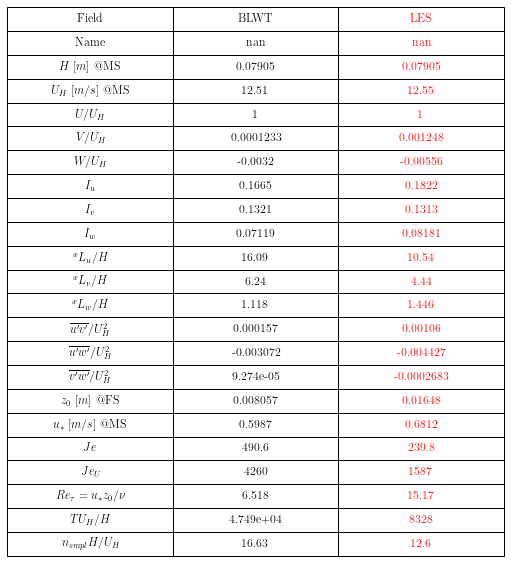

In [ ]:
fig, _ = profs.plotParamsTable( colTxtColors=['k','r','b','g'], fontSz=12, 
                                params = 'all',
                                # params = wind.mathName(['H','Iu','Iv','Iw']),
                                )
if saveFigs:
    fig.savefig(figDir+"paramsTable_vel.svg",format='svg',dpi=1200, bbox_inches='tight')

No velocity time history found for vonKarman. Skipping velocity statistics calculation.
Figure saved: D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/__plots//spectra.svg


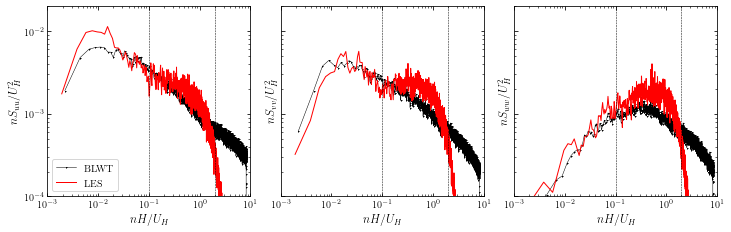

In [ ]:
vonk = wind.profile(name='vonKarman', )
Sp = wtVel_E2.SpectH.copy()
n = np.logspace(-3, 3, 100)
Suu, Svv, Sww = wind.vonKarmanSpectra(n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)
vonk.SpectH = wind.spectra(name=vonk.name, Z=H, Suu=Suu, Svv=Svv, Sww=Sww, n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)

# es74.SpectH.name = 'ESDU'
# profss = wind.Profiles([WT_cp.profile, LES_Cp.profile, es74, es85, vonk]) #, es85])
profss = wind.Profiles([WT_cp.profile, LES_Cp.profile, ]) #, es85])
LES_Cp.profile.SpectH.name = 'LES'
WT_cp.profile.SpectH.name = 'BLWT'

clb = 0
r = [1.0, clb, clb, 1.0]
b = [clb, clb, clb, 1.0]
kwargs_plt=[{'color': b, 'markerfacecolor':b, 'markeredgecolor':b, 'alpha':1, 'linewidth':0.5, 'linestyle': '-',    'marker': '+', 'markersize':1},
                            {'color': r, 'markerfacecolor':r, 'markeredgecolor':r, 'alpha':1, 'linewidth':1, 'linestyle': '-',    'marker': '', 'markersize':2},
                            {'color': 'g', 'linewidth':2, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            {'color': 'b', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            {'color': 'm', 'linewidth':2, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            ]

fig, _ = profss.plotSpectra(figsize=[12,3.5], #figsize=[12,2.5], #
                        normalize=True,
                        xLimits=[1e-3, 10], 
                        yLimits=[[1e-4,2e-2],[1e-4,2e-2],[1e-4,2e-2]], 
                        # yLimits=[[5e-4,2e-2],[5e-4,2e-2],[5e-4,2e-2]], 
                        wspace=0.15, shareY=True, normU='U', normZ='Z',
                        showSubPlotLabels=False,
                        subPlotLabel_xy=[0.9,0.9],
                        kwargs_plt=kwargs_plt,
                        kwargs_ax={'gridMajor':False, 'gridMinor':False},
                        )
# fig.tight_layout()
# reduce the gap between subplots
# fig.subplots_adjust(wspace=0.37)

if saveFigs:
    fig.savefig(figDir+'spectra_4ppt_wtLES.svg', format='svg',dpi=600, bbox_inches='tight')
    # fig.savefig(figDir+'spectra.svg', format='svg',dpi=600, bbox_inches='tight')
    # fig.savefig(figDir+'spectra.pdf', format='pdf',dpi=600, bbox_inches='tight')
    print(f"Figure saved: {figDir}/spectra.svg")
# fig.savefig(figDir+'spectra_clipped.svg', format='svg',dpi=600, bbox_inches='tight')

0.6812341226173684
0.3639453215319163
1.6723857914750933


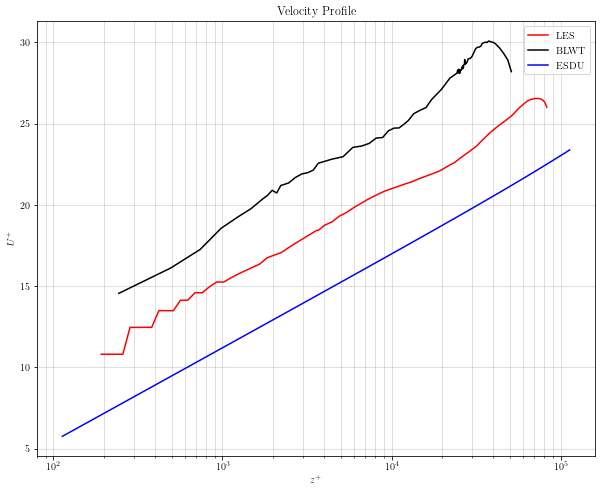

In [ ]:
wtVel_E2.fluidDensity = 1.0
wtVel_E2.fluidKinematicViscosity = 1.48e-5
es85.fluidDensity = 1.0
es85.fluidKinematicViscosity = 1.48e-5 * (50*50)/25
print(lesVel_E2.shearVelocity)
print(wtVel_E2.shearVelocity)
print(es85.shearVelocity)
# print(lesVel_E2.fluidDensity)

fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot()

ax.semilogx(lesVel_E2.Z_plus, lesVel_E2.U_plus, 'r', label='LES')
ax.semilogx(wtVel_E2.Z_plus, wtVel_E2.U_plus, 'k', label='BLWT')
ax.semilogx(es85.Z_plus, es85.U_plus, 'b', label='ESDU')
# ax.set_xlim([1, 1e4])
# ax.set_ylim([0, 25])
ax.set_xlabel('$z^+$')
ax.set_ylabel('$U^+$')
ax.legend()
ax.grid(True, which='both', axis='both', alpha=0.5)
ax.set_title('Velocity Profile')

plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter

def add_cbar(fig, ax, im, ticks, label, labelpad=10, aspect=20, shrink=0.5, pad=0.08, inset_loc=[0.0, 1.0, 1.0, 0.1], orientation='horizontal',
             **kwargs):
    ax_cbar = ax.inset_axes(inset_loc)
    ax_cbar.axis('on')  
    cbar = fig.colorbar(im, cax=ax_cbar, orientation=orientation,aspect=aspect,shrink=shrink,pad=pad, **kwargs)
    cbar.set_ticks(ticks)
    if orientation=='horizontal':
        cbar.ax.set_xlabel(label, fontsize=14, rotation=0, labelpad=labelpad)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.85, pos.width*0.8, pos.height*0.05]
        ax_cbar.set_position(new_pos)
    else:
        cbar.ax.set_ylabel(label, fontsize=14, rotation=0, labelpad=labelpad)
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.yaxis.set_label_position('right')
        pos = ax_cbar.get_position()
        new_pos = [pos.x0+pos.width*0.85, pos.y0+pos.height*0.1, pos.width*0.05, pos.height*0.8]
        ax_cbar.set_position(new_pos)
    return ax_cbar, cbar

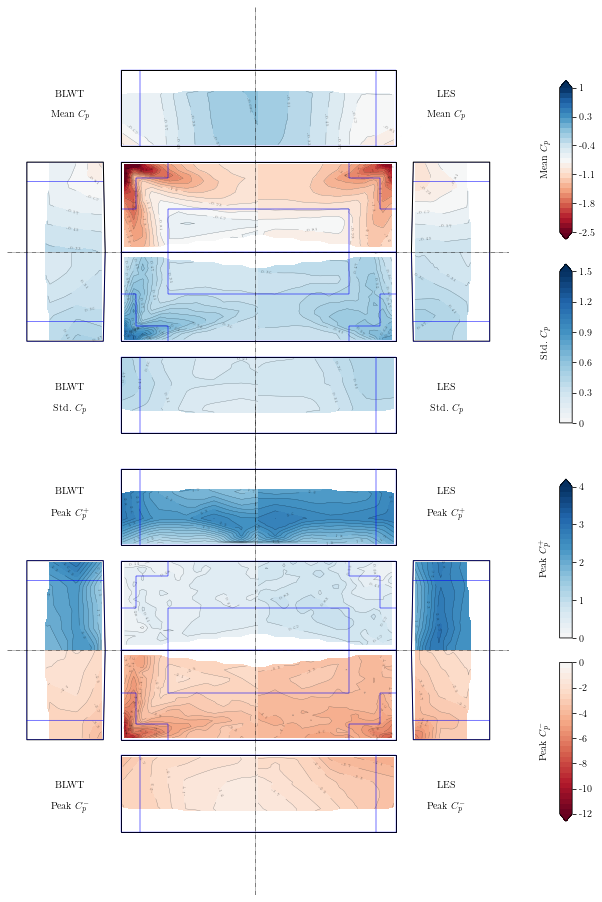

In [ ]:
fs = 10
cbar_offset = 1.2

# # for BBAA abstract
# cbar_offset = 1.1
# figsize = [3.5,7]

kwargs_Edge_zones={'color':'b', 'lw':0.3, 'ls':'-', 'marker':''}

figsize = [9,18]
fig, axs = plt.subplots(4,2,figsize=figsize)

ax = axs[0,0]
cp = WT_cp
ax.annotate('BLWT\n\n'+ wind.fullName('mean',abbreviate=True), xy=(0.25, 0.6), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
vals = np.linspace(-2.5, 1.0, 6)
fld, fldrange, ticks = 'mean', [vals[0], vals[-1]], vals
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True),)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge=kwargs_Edge_zones)
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.invert_yaxis()
ax.invert_xaxis()
ax.axis('off')

ax = axs[0,1]
cp = LES_Cp
ax.annotate('LES\n\n'+ wind.fullName('mean',abbreviate=True), xy=(0.75, 0.6), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True),)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge=kwargs_Edge_zones)
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.invert_yaxis()
ax.axis('off')

ax_cbar1 = ax.inset_axes([cbar_offset, 0.05, 0.05, 0.65])
ax_cbar1.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='vertical',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_ylabel(wind.fullName(fld,abbreviate=True), fontsize=fs, rotation=90, labelpad=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
cbar.ax.yaxis.set_label_position('left')


ax = axs[1,0]
cp = WT_cp
ax.annotate('BLWT\n\n'+ wind.fullName('std',abbreviate=True), xy=(0.25, 0.4), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
vals = np.linspace(0, 1.5, 6)
fld, fldrange, ticks = 'std', [vals[0], vals[-1]], vals
im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
cp.plotEdges(ax=ax, showName=False)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge=kwargs_Edge_zones)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.invert_xaxis()
ax.axis('off')

ax = axs[1,1]
cp = LES_Cp
ax.annotate('LES\n\n'+ wind.fullName('std',abbreviate=True), xy=(0.75, 0.4), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
cp.plotEdges(ax=ax, showName=False)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge=kwargs_Edge_zones)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.axis('off')

ax_cbar2 = ax.inset_axes([cbar_offset, 0.30, 0.05, 0.65])
ax_cbar2.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='vertical',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_ylabel(wind.fullName(fld,abbreviate=True), fontsize=fs, rotation=90, labelpad=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
cbar.ax.yaxis.set_label_position('left')




ax = axs[2,0]
cp = WT_cp
# ax.set_title('WT: '+ wind.fullName('peakMax',abbreviate=True))
ax.annotate('BLWT\n\n'+ wind.fullName('peakMax',abbreviate=True), xy=(0.25, 0.6), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
vals = np.linspace(0, 4.0, 5)
fld, fldrange, ticks = 'peakMax', [vals[0], vals[-1]], vals
im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
cp.plotEdges(ax=ax, showName=False)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge=kwargs_Edge_zones)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')


ax = axs[2,1]
cp = LES_Cp
# ax.set_title('LES: '+ wind.fullName('peakMax',abbreviate=True))
ax.annotate('LES\n\n'+ wind.fullName('peakMax',abbreviate=True), xy=(0.75, 0.6), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
cp.plotEdges(ax=ax, showName=False)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge=kwargs_Edge_zones)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.invert_yaxis()
ax.axis('off')

ax_cbar3 = ax.inset_axes([cbar_offset, 0.05, 0.05, 0.65])
ax_cbar3.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar3, orientation='vertical',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_ylabel(wind.fullName(fld,abbreviate=True), fontsize=fs, rotation=90, labelpad=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
cbar.ax.yaxis.set_label_position('left')




ax = axs[3,0]
cp = WT_cp
# ax.set_title('WT: '+ wind.fullName('peakMin',abbreviate=True))
ax.annotate('BLWT\n\n'+ wind.fullName('peakMin',abbreviate=True), xy=(0.25, 0.4), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
vals = np.linspace(-12.0, 0, 7)
fld, fldrange, ticks = 'peakMin', [vals[0], vals[-1]], vals
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='min',
                                cmap=wind.sub_cmap(cmap='RdBu', stop=0.5, n=30))
cp.plotEdges(ax=ax, showName=False)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge=kwargs_Edge_zones)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.invert_xaxis()
ax.axis('off')

ax = axs[3,1]
cp = LES_Cp
# ax.set_title('LES: '+ wind.fullName('peakMin',abbreviate=True))
ax.annotate('LES\n\n'+ wind.fullName('peakMin',abbreviate=True), xy=(0.75, 0.4), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='min',
                                cmap=wind.sub_cmap(cmap='RdBu', stop=0.5, n=30))
cp.plotEdges(ax=ax, showName=False)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge=kwargs_Edge_zones)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.axis('off')

ax_cbar4 = ax.inset_axes([cbar_offset, 0.30, 0.05, 0.65])
ax_cbar4.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar4, orientation='vertical',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_ylabel(wind.fullName(fld,abbreviate=True), fontsize=fs, rotation=90, labelpad=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
cbar.ax.yaxis.set_label_position('left')



# draw a vertical line across multiple subplots down the middle
for ax in axs[:,0]:
    ax.axvline(x=0.0, color='k', lw=0.5, dashes=(10,2,2,2))
# draw two horizontal lines between rows 1 and 2, and 3 and 4
for ax in axs[1:4,:].flatten():
    ax.axhline(y=0.0, color='k', lw=0.5, dashes=(10,2,2,2))
    


vshift = 0.07
fig.subplots_adjust(hspace=0.0, wspace=0.0)
for ax in axs[2:4,:].flatten():
    pos = ax.get_position()
    new_pos = [pos.x0, pos.y0+vshift, pos.width, pos.height]
    ax.set_position(new_pos)


plt.show()
# if saveFigs:
#     fig.savefig(figDir+"CpStats_contour_merged.png",format='png',dpi=300, bbox_inches='tight')
#     fig.savefig(figDir+"CpStats_contour_merged.pdf",format='pdf',dpi=300, bbox_inches='tight')

fig.savefig(figDir+"CpStats_contour_merged_tiny_4ppt.png",format='png',dpi=300, bbox_inches='tight')
# fig.savefig(figDir+"CpStats_contour_merged_tiny_4ppt.pdf",format='pdf',dpi=300, bbox_inches='tight')



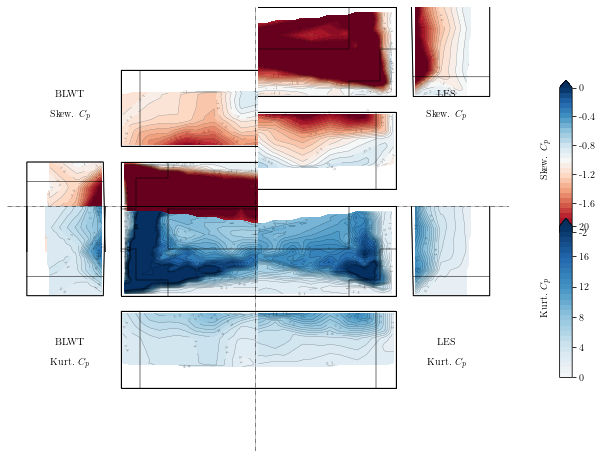

In [ ]:
# separate figure for skewness and kurtosis
fig, axs = plt.subplots(2,2,figsize=[9,9])

ax = axs[0,0]
cp = WT_cp
ax.annotate('BLWT\n\n'+ wind.fullName('skewness',abbreviate=True), xy=(0.25, 0.6), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
vals = np.linspace(-2, 0, 6)
fld, fldrange, ticks = 'skewness', [vals[0], vals[-1]], vals
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True),)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge={'color':'k', 'lw':0.3, 'ls':'-', 'marker':''})
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.invert_yaxis()
ax.invert_xaxis()
ax.axis('off')

ax = axs[0,1]
cp = LES_Cp
ax.annotate('LES\n\n'+ wind.fullName('skewness',abbreviate=True), xy=(0.75, 0.6), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True),)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge={'color':'k', 'lw':0.3, 'ls':'-', 'marker':''})
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.invert_yaxis()
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.axis('off')

ax_cbar1 = ax.inset_axes([cbar_offset, 0.05, 0.05, 0.65])
ax_cbar1.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='vertical',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_ylabel(wind.fullName(fld,abbreviate=True), fontsize=fs, rotation=90, labelpad=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
cbar.ax.yaxis.set_label_position('left')


ax = axs[1,0]
cp = WT_cp
ax.annotate('BLWT\n\n'+ wind.fullName('kurtosis',abbreviate=True), xy=(0.25, 0.4), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
vals = np.linspace(0, 20, 6)
fld, fldrange, ticks = 'kurtosis', [vals[0], vals[-1]], vals
im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
cp.plotEdges(ax=ax, showName=False)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge={'color':'k', 'lw':0.3, 'ls':'-', 'marker':''})
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.invert_xaxis()
ax.axis('off')

ax = axs[1,1]
cp = LES_Cp
ax.annotate('LES\n\n'+ wind.fullName('kurtosis',abbreviate=True), xy=(0.75, 0.4), xycoords='axes fraction', ha='center', va='center', fontsize=fs)
im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
cp.plotEdges(ax=ax, showName=False)
cp.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge={'color':'k', 'lw':0.3, 'ls':'-', 'marker':''})
ax.axis('equal')
ax.set_xlim([0, 0.25])
ax.set_ylim([-0.25, 0])
ax.axis('off')

ax_cbar2 = ax.inset_axes([cbar_offset, 0.30, 0.05, 0.65])
ax_cbar2.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='vertical',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_ylabel(wind.fullName(fld,abbreviate=True), fontsize=fs, rotation=90, labelpad=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
cbar.ax.yaxis.set_label_position('left')

# draw a vertical line across multiple subplots down the middle
for ax in axs[:,0]:
    ax.axvline(x=0.0, color='k', lw=0.5, dashes=(10,2,2,2))
# draw two horizontal lines between rows 1 and 2, and 3 and 4
for ax in axs[1:4,:].flatten():
    ax.axhline(y=0.0, color='k', lw=0.5, dashes=(10,2,2,2))
    
    
vshift = 0.07
fig.subplots_adjust(hspace=0.0, wspace=0.0)
for ax in axs[1:2,:].flatten():
    pos = ax.get_position()
    new_pos = [pos.x0, pos.y0+vshift, pos.width, pos.height]
    ax.set_position(new_pos)
    
plt.show()
# if saveFigs:
#     fig.savefig(figDir+"CpStats_contour_merged_skewness_kurtosis.png",format='png',dpi=300, bbox_inches='tight')
#     fig.savefig(figDir+"CpStats_contour_merged_skewness_kurtosis.pdf",format='pdf',dpi=300, bbox_inches='tight')

fig.savefig(figDir+"CpStats_contour_merged_skewness_kurtosis_tiny.png",format='png',dpi=300, bbox_inches='tight')

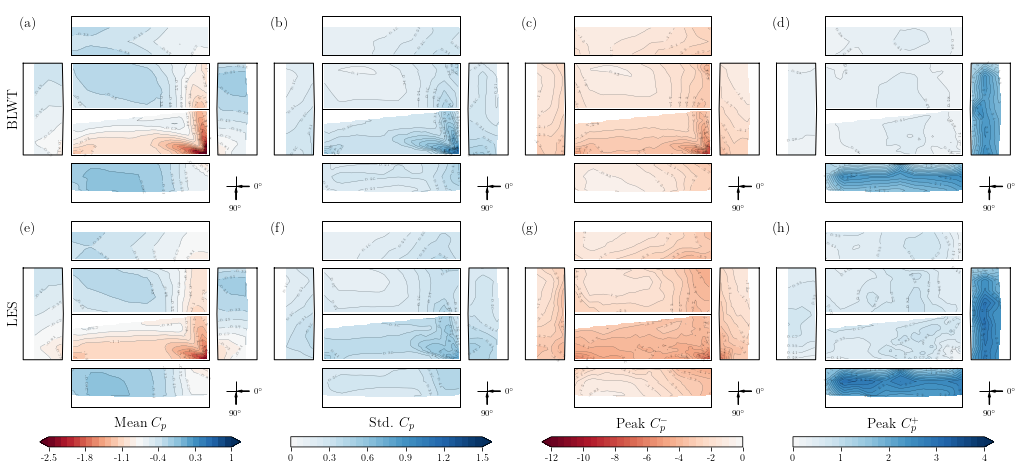

In [ ]:
from matplotlib.ticker import FuncFormatter

figsize = [18,11.3] # [15,10]
fig, axs = plt.subplots(3,4,figsize=figsize)
ax_cbar1 = axs[2,0]
ax_cbar2 = axs[2,1]
ax_cbar3 = axs[2,2]
ax_cbar4 = axs[2,3]

# fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

subLbls = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)',
           '(m)', '(n)', '(o)', '(p)', '(q)', '(r)', '(s)', '(t)', '(u)', '(v)', '(w)', '(x)']

names = ['BLWT', 'LES']

for i, cp in enumerate([WT_cp_avg, LES_Cp]):

    vals = np.linspace(-2.5, 1.0, 6)
    fld, fldrange, ticks = 'mean', [vals[0], vals[-1]], vals
    
    ax = axs[i,0]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True),)
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.annotate(names[i], xy=(0.02, 0.5), xycoords='axes fraction', fontsize=14, ha='right', va='center', rotation=90,
                # bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2))
                bbox=dict(boxstyle="round", fc="w", ec="None", pad=0.1))
    ax.annotate(f"{subLbls[i*4]}", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, ha='left', va='top', rotation=0,
                bbox=dict(boxstyle="round", fc="w", ec="None", pad=0.1))
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar1.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar1.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.85, pos.width*0.8, pos.height*0.05]
        ax_cbar1.set_position(new_pos)
        

    vals = np.linspace(0, 1.5, 6)
    fld, fldrange, ticks = 'std', [vals[0], vals[-1]], vals
    ax = axs[i,1]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.annotate(f"{subLbls[i*4 + 1]}", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, ha='left', va='top', rotation=0,
                bbox=dict(boxstyle="round", fc="w", ec="None", pad=0.1))
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar2.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar2.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.85, pos.width*0.8, pos.height*0.05]
        ax_cbar2.set_position(new_pos)


    vals = np.linspace(-12.0, 0, 7)
    fld, fldrange, ticks = 'peakMin', [vals[0], vals[-1]], vals
    ax = axs[i,2]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='min',
                                 cmap=wind.sub_cmap(cmap='RdBu', stop=0.5, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.annotate(f"{subLbls[i*4 + 2]}", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, ha='left', va='top', rotation=0,
                bbox=dict(boxstyle="round", fc="w", ec="None", pad=0.1))
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar3.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar3, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar3.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.85, pos.width*0.8, pos.height*0.05]
        ax_cbar3.set_position(new_pos)


    vals = np.linspace(0, 4.0, 5)
    fld, fldrange, ticks = 'peakMax', [vals[0], vals[-1]], vals
    ax = axs[i,3]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.annotate(f"{subLbls[i*4 + 3]}", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, ha='left', va='top', rotation=0,
                bbox=dict(boxstyle="round", fc="w", ec="None", pad=0.1))
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar4.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar4, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar4.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.85, pos.width*0.8, pos.height*0.05]
        ax_cbar4.set_position(new_pos)

# if saveFigs:
#     fileName = figDir+f"CpContour.svg"
#     fig.savefig(fileName,format='svg',dpi=600, bbox_inches='tight')
#     print(f"Figure saved to {fileName}")
    

In [ ]:
# for aoaI in [0,3,4,8]:

#     fig, axs = plt.subplots(2,1,figsize=[12,15])
#     ax = axs[0]
#     ax_cbar1 = axs[1]

#     im = WT_cp.plotTapCpStatContour(ax=ax, dxnIdx=aoaI,fieldName='mean',fldRange=[-2.5, 1.0],nLvl=30,title=wind.fullName('mean',abbreviate=True),)
#     WT_cp.plotEdges(ax=ax, showName=False)
#     WT_cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[WT_cp.AoA[aoaI]], textOffsetFactor=3.0)
#     ax.axis('equal')
#     ax.axis('off')

#     ax_cbar1.axis('on')
#     cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
#     cbar.set_ticks(np.linspace(-2.5, 1.0, 6))
#     cbar.ax.set_xlabel(wind.fullName('mean',abbreviate=True), fontsize=14, rotation=0, labelpad=10)
#     cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
#     cbar.ax.xaxis.set_label_position('top')
#     pos = ax_cbar1.get_position()
#     new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.85, pos.width*0.8, pos.height*0.05]
#     ax_cbar1.set_position(new_pos)

#     plt.show()

In [ ]:
# bldgLst = [LES_Cp, LES_Cp_corrected, WT_cp_avg]
bldgLst = [LES_Cp, LES_Cp_corrected, WT_cp_avg]
bldgLst.extend(WT_cp_all.memberBldgs)
print(len(bldgLst))

cp_comp = wind.BldgCps(bldgLst) #[WT_cp, LES_Cp, LES_Cp_corrected])

# print(type(WT_cp_all.memberBldgs))
# for b, bldg in enumerate(WT_cp_all.memberBldgs):
#     bldg.name = f'BLWT-r{b+1}'
WT_cp_all.memberBldgs[0].name = 'BLWT (all runs)'
WT_cp_avg.name = 'BLWT (avg.)'
LES_Cp.name = 'LES (uncorrected)'
LES_Cp_corrected.name = 'LES (expo. corrected)'

10
Number of member bldgs: 10


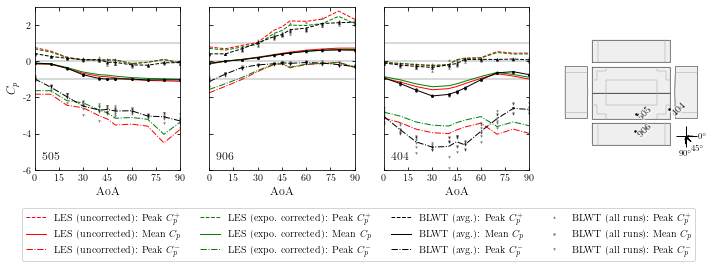

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# tapsToPlot=np.sort([405, 1806, 1709, 1006, 406, 1807, 1915, 1611, 1903, 1611])
# tapsToPlot=[906, 505, 213, 1212, 1709, 404, 712]
tapsToPlot=[505, 906, 404]

fields=['peakMax','mean','peakMin']
mrkrs=['^','o','v']
c = 'k'
a = 0.5
alphas = [1,1,1,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a,a]
cols=['r','g','k',c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c]
ls=['-','-','-','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']
ls2=['--','-','-.']
mrkrSize=[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]
mrkrFaceColor=['r','g','k',c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c,c]
lw=[1,1,1,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3]
kwargs_perFld = [[{'color':cols[b], 
                    'marker':mrkrs[f] if b>2 else None, 
                    'ls':ls[b] if b>2 else ls2[f],
                    'markersize':mrkrSize[b],
                    'markerfacecolor':mrkrFaceColor[b],
                    'alpha':alphas[b],
                    'mew':lw[b],
                    'linewidth':lw[b],
                    } for f in range(len(fields))]
                    for b in range(cp_comp.N_bldgs)]
includeInLegend = [True if b<4 else False for b in range(cp_comp.N_bldgs)]

figs, all_axes = cp_comp.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot, nCols=4, xlim=[-5,95], 
                                            #   xticks=[0,10,20,30,40,50,60,70,80,90],
                                        xticks=[0, 15, 30, 45, 60, 75, 90],
                                        nRows=1, 
                                        # figsize=[12,8], # for thesis document
                                        figsize=[12,3], # for ppt
                                        fldRange=[-6,3.0], nLgndCols=4, 
                                        # nRows=3, figsize=[12,9], fldRange=[-12,3.0], nLgndCols=3, 
                                        fields=['peakMax','mean','peakMin'], 
                                        kwargs_perFld=kwargs_perFld, includeInLegend=includeInLegend,
                                        legend_bbox_to_anchor=(0.5, -0.03),
                                        pageNo_xy=(0.5, 0.05), showPageNo=False, kwargs_axFrmt={'gridMajor':False, 'gridMinor':False},
                                        )


fig = figs[0]
zoom = False

divider = make_axes_locatable(all_axes[0][-1,-1])
ax = divider.append_axes("bottom", size="1800%", pad=0.0,)

bldg.plotEdges(ax=ax, showName=False, fill=True, kwargs_Edge = { 'color': 'k','lw': 0.5,'ls': '-' })
bldg.plotZones(ax=ax, showLegend=False, fill=False, kwargs_Edge = { 'color': 'darkgray','lw': 0.3,'ls': '-' })
bldg.plotTaps(ax=ax, tapsToPlot=tapsToPlot, showTapNo=True, 
              textOffset_tapNo=[0.002,0.03], 
              # textOffset_tapNo=[-0.001,0.002],
              kwargs_text= { 'ha': 'left','va': 'top','color': 'k','backgroundcolor': [1, 1, 1, 0.5],'fontsize': 10,'rotation': 45,
                            'bbox': dict(boxstyle="round", fc=[1, 1, 1, 0.5], ec="None", pad=0.0),})
if not zoom:
    bldg.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 45, 90], textOffsetFactor=4.0)
ax.axis('equal')
_ = ax.axis('off')

if zoom:
    ax.set_xlim([0.1,0.15])
    ax.set_ylim([-0.1,-0.04])
    ax = make_axes_locatable(all_axes[0][-1,-2]).append_axes("bottom", size="1800%", pad=0.0,)
    bldg.plotEdges(ax=ax, showName=False, fill=True, kwargs_Edge = { 'color': 'k','lw': 0.5,'ls': '-' })
    bldg.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 45, 90], textOffsetFactor=4.0)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.axis('equal')
    box_x = [xlim[0], xlim[0], xlim[1], xlim[1], xlim[0]]
    box_y = [ylim[0], ylim[1], ylim[1], ylim[0], ylim[0]]
    ax.plot(box_x, box_y, 'r--', linewidth=0.8)
    ax.axis('off')

plt.show()

if saveFigs:
    fig.savefig(figDir+f"CpStatsPerAoA_selectTaps_4ppt.v5.svg",format='svg',dpi=600, bbox_inches='tight')
    
    # fig.savefig(figDir+f"CpStatsPerAoA_selectTaps.svg",format='svg',dpi=600, bbox_inches='tight')
    # fig.savefig(figDir+f"CpStatsPerAoA_selectTaps.pdf",format='pdf',dpi=600, bbox_inches='tight')
    

In [ ]:
print(validator_2.error_CpStats.keys())
print(validator_2.error_CpStats['mean']['perAoA'][45.0].keys())
print(validator_2.error_CpStats['kurtosis']['perAoA'][0.0]['RMSE'])

dict_keys(['AoA', 'tapNo', 'mean', 'std', 'peakMin', 'peakMax', 'skewness', 'kurtosis'])
dict_keys(['MAE', 'RMSE', 'NMAE', 'NRMSE'])
0.7600485491306976


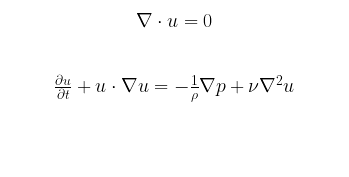

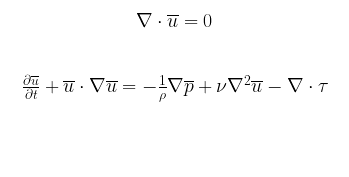

In [ ]:
# write the Navier Stokes equations and export as PDF, SVG

fig, ax = plt.subplots(figsize=[6,3])

# continuety equation
_ = ax.text(0.5, 0.9, r"$\nabla \cdot u = 0$", fontsize=20, ha='center', va='center')

# NS equation
_ = ax.text(0.5, 0.5, r"$\frac{\partial u}{\partial t} + u \cdot \nabla u = -\frac{1}{\rho} \nabla p + \nu \nabla^2 u$", fontsize=20, ha='center', va='center')

# turn off axes
ax.axis('off')

# fig.savefig(figDir+f"NavierStokesEquations.pdf",format='pdf',dpi=600, bbox_inches='tight')
fig.savefig(figDir+f"NavierStokesEquations.svg",format='svg',dpi=600, bbox_inches='tight')

# filtered NS for LES (use overbar for filtered quantities)
fig, ax = plt.subplots(figsize=[6,3])

# continuety equation
_ = ax.text(0.5, 0.9, r"$\nabla \cdot \overline{u} = 0$", fontsize=20, ha='center', va='center')

# NS equation
_ = ax.text(0.5, 0.5, r"$\frac{\partial \overline{u}}{\partial t} + \overline{u} \cdot \nabla \overline{u} = -\frac{1}{\rho} \nabla \overline{p} + \nu \nabla^2 \overline{u} - \nabla \cdot \tau$", fontsize=20, ha='center', va='center')

# turn off axes
ax.axis('off')

# fig.savefig(figDir+f"NavierStokesEquations_LES.pdf",format='pdf',dpi=600, bbox_inches='tight')
fig.savefig(figDir+f"NavierStokesEquations_LES.svg",format='svg',dpi=600, bbox_inches='tight')


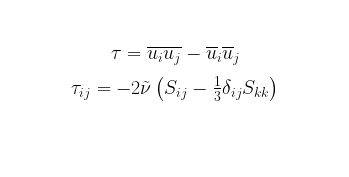

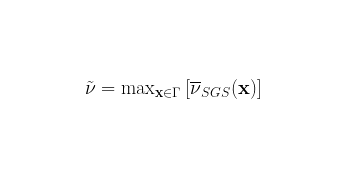

In [ ]:

# write the SGS model for LES (use tilde for SGS quantities)
fig, ax = plt.subplots(figsize=[6,3])

# SGS stress
_ = ax.text(0.5, 0.7, r"$\tau = \overline{u_i u_j} - \overline{u}_i \overline{u}_j$", fontsize=20, ha='center', va='center')

# SGS stress tensor as a function of SGS viscosity and SGS strain rate
_ = ax.text(0.5, 0.5, r"$\tau_{ij} = -2 \tilde{\nu} \left( S_{ij} - \frac{1}{3} \delta_{ij} S_{kk} \right)$", fontsize=20, ha='center', va='center')

ax.axis('off')
figdir2 = r'D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\thesisDoc\publicLecture\figures/'
fig.savefig(figdir2+f"SGSModel_LES.svg",format='svg',dpi=600, bbox_inches='tight')


# write the following equation to file
# \tilde{\nu}= \max_{\bm{x}\in\Gamma} \left[\overline{\nu}_{SGS}(\bm{x})\right]
fig, ax = plt.subplots(figsize=[6,3])
_ = ax.text(0.5, 0.5, r"$\tilde{\nu}= \max_{\mathbf{x}\in\Gamma} \left[\overline{\nu}_{SGS}(\mathbf{x})\right]$", fontsize=20, ha='center', va='center')
ax.axis('off')
fig.savefig(figdir2+f"SGSModel_LES_nuTilde.svg",format='svg',dpi=600, bbox_inches='tight')


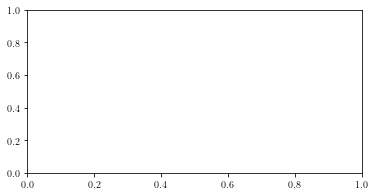

In [ ]:
###### write the following table onto a figure and save as svg


# \begin{table}[ht]
#     \begin{tabular}{|r|C{2.5cm}|C{2.5cm}|C{2.5cm}|C{2.5cm}|}
#         \hline
#         Case name   & $\tilde{\nu}$ $[m^2/s]$   & $\tilde{\nu}/\nu_{\text{laminar}}$  & $Re_H$  & $\widetilde{Re}_H$    \\ \hline
#         USI-CM      & $4.64\times10^{-4}$       & 15.3                              & 26,403        & 1,683                 \\ \hline
#         USI-MM      & $2.03\times10^{-4}$       & 6.7                               & 26,403        & 3,842                 \\ \hline
#         USI-FM      & $1.03\times10^{-4}$       & 3.4                               & 26,403        & 7,567                 \\ \hline
#         ABL-CM      & $2.77\times10^{-4}$       & 9.1                               & 15,313        & 1,690                 \\ \hline
#         ABL-MM      & $1.41\times10^{-4}$       & 4.6                               & 15,313        & 3,316                 \\ \hline
#         ABL-FM      & $6.79\times10^{-5}$       & 2.2                               & 15,313        & 6,993                 \\ \hline
#     \end{tabular}
# \end{table}

fig, ax = plt.subplots(figsize=[6,3])


In [ ]:

# fig, _ = validator_2.plotError_CpStats(modelLabel='LES', targetLabel='BLWT', percentLinesAt=[], figsize_per_ax=[4,3], 
#                                      showErrTxt=True, fields=['peakMin'], nPltCols=1,
#                                     xyLims={'mean':[-3.5, 1], 'skewness': [-5, 3], 'kurtosis': [-5, 30]}, cols=[plt.cm.seismic(i) for i in np.linspace(0, 1, len(LES_Cp.AoA))], showLegend=True,
#                                     kwargs_legend={'loc': 'upper left', 'ncol': 2, 'fontsize': 6},
#                                     kwargs_mainPlot={'marker': 'o','linestyle': '', 'markeredgecolor':'k', 'ms':3, 'markeredgewidth':0.5},
#                                     )

# fig.savefig(figDir+'CpStatsErrorNew_tiny.svg', bbox_inches='tight', dpi=300)
# print(f"Figure saved: {figDir}CpStatsErrorNew_small.svg")


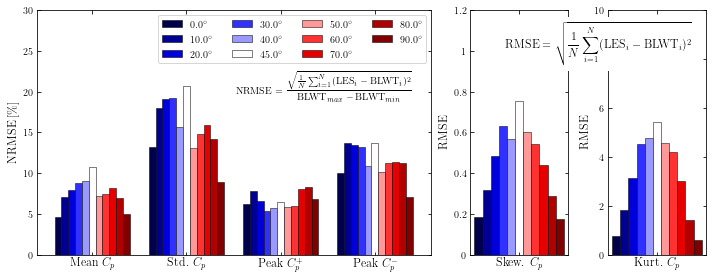

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4.5))

gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

# # _ = validator.plotError_CpStats(xyLims={'skewness': [-5, 3], 'kurtosis': [-0.5, 30]})

_, _ = validator_2.plotError_barChart_CpStats(
                                        axs=[ax1], fig=fig, 
                                        fields=['mean','std','peakMax','peakMin',
                                                        # 'skewness','kurtosis',
                                                        ], lumpAllAoAs=False, 
                                                # errorType=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'], 
                                                errorType=['NRMSE'],
                                        kwargs_legend={'loc':'upper right', 'ncol':4}, showErrEqn=True,
                                        showSubPlotLabels=False, 
                                        # cols=wind.def_cols, 
                                        # take the colors from jet colormap
                                        cols=[plt.cm.seismic(i) for i in np.linspace(0, 1, len(LES_Cp.AoA))],
                                        figsize_per_ax=[6,4], nPltCols=2, yLims={'NMAE':[0, 20], 'NRMSE':[0, 30], 'MAE':[0, 0.8], 'RMSE':[0, 1.0], '$R^2$':[0, 1.5], 'SMAPE':[0, 50], 'Y-INTERCEPT':[-0.25, 0.25], 'SLOPE':[0, 1.5]},
                                        kwargs_errEqnTxt=[{'xy':(0.95, 0.75), 'xycoords':'axes fraction', 'ha':'right', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':10},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          ],
                                   )


_, _ = validator_2.plotError_barChart_CpStats(
                                        axs=[ax2], fig=fig, 
                                        fields=['skewness'], lumpAllAoAs=False, 
                                                # errorType=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'], 
                                                errorType=['RMSE'],
                                        kwargs_legend={'loc':'upper right', 'ncol':4},
                                        showSubPlotLabels=False, showLegend=False,
                                        showErrEqn=False,
                                        # cols=wind.def_cols, 
                                        # take the colors from jet colormap
                                        cols=[plt.cm.seismic(i) for i in np.linspace(0, 1, len(LES_Cp.AoA))],
                                        figsize_per_ax=[6,4], nPltCols=2, 
                                        yLims={'NMAE':[0, 20], 'NRMSE':[0, 30], 'MAE':[0, 0.8], 'RMSE':[0, 1.2], },
                                        kwargs_errEqnTxt=[{'xy':(0.23, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          ],
                                   )

_, _ = validator_2.plotError_barChart_CpStats(
                                        axs=[ax3], fig=fig, 
                                        fields=['kurtosis'], lumpAllAoAs=False, 
                                                # errorType=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'], 
                                                errorType=['RMSE'],
                                        kwargs_legend={'loc':'upper right', 'ncol':4},
                                        showSubPlotLabels=False, showLegend=False,
                                        showErrEqn=True,
                                        # cols=wind.def_cols, 
                                        # take the colors from jet colormap
                                        cols=[plt.cm.seismic(i) for i in np.linspace(0, 1, len(LES_Cp.AoA))],
                                        figsize_per_ax=[6,4], nPltCols=2, 
                                        yLims={'NMAE':[0, 20], 'NRMSE':[0, 30], 'MAE':[0, 0.8], 'RMSE':[0, 10.0], },
                                        kwargs_errEqnTxt=[{'xy':(-0.1, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,1], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          ],
                                   )

plt.show()
if saveFigs:
        # fig.savefig(figDir+'CpStatsError_barChart_small.svg', bbox_inches='tight')
        fig.savefig(figDir+'CpStatsError_barChart_small_4ppt.svg', bbox_inches='tight')
        # fig.savefig(figDir+'CpStatsError_barChart_small.pdf', bbox_inches='tight')


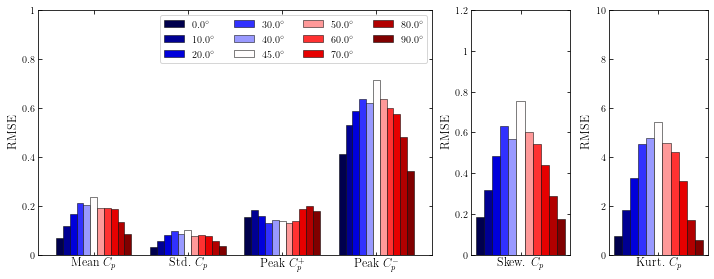

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4.5))

gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

# # _ = validator.plotError_CpStats(xyLims={'skewness': [-5, 3], 'kurtosis': [-0.5, 30]})

_, _ = validator_2.plotError_barChart_CpStats(
                                        axs=[ax1], fig=fig, 
                                        fields=['mean','std','peakMax','peakMin',
                                                        # 'skewness','kurtosis',
                                                        ], lumpAllAoAs=False, 
                                                # errorType=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'], 
                                                errorType=['RMSE'],
                                        kwargs_legend={'loc':'upper right', 'ncol':4}, showErrEqn=False,
                                        showSubPlotLabels=False, 
                                        # cols=wind.def_cols, 
                                        # take the colors from jet colormap
                                        cols=[plt.cm.seismic(i) for i in np.linspace(0, 1, len(LES_Cp.AoA))],
                                        figsize_per_ax=[6,4], nPltCols=2, yLims={'NMAE':[0, 20], 'NRMSE':[0, 30], 'MAE':[0, 0.8], 'RMSE':[0, 1.0], '$R^2$':[0, 1.5], 'SMAPE':[0, 50], 'Y-INTERCEPT':[-0.25, 0.25], 'SLOPE':[0, 1.5]},
                                        kwargs_errEqnTxt=[{'xy':(0.95, 0.75), 'xycoords':'axes fraction', 'ha':'right', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':10},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          ],
                                   )


_, _ = validator_2.plotError_barChart_CpStats(
                                        axs=[ax2], fig=fig, 
                                        fields=['skewness'], lumpAllAoAs=False, 
                                                # errorType=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'], 
                                                errorType=['RMSE'],
                                        kwargs_legend={'loc':'upper right', 'ncol':4},
                                        showSubPlotLabels=False, showLegend=False,
                                        showErrEqn=False,
                                        # cols=wind.def_cols, 
                                        # take the colors from jet colormap
                                        cols=[plt.cm.seismic(i) for i in np.linspace(0, 1, len(LES_Cp.AoA))],
                                        figsize_per_ax=[6,4], nPltCols=2, 
                                        yLims={'NMAE':[0, 20], 'NRMSE':[0, 30], 'MAE':[0, 0.8], 'RMSE':[0, 1.2], },
                                        kwargs_errEqnTxt=[{'xy':(0.23, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          ],
                                   )

_, _ = validator_2.plotError_barChart_CpStats(
                                        axs=[ax3], fig=fig, 
                                        fields=['kurtosis'], lumpAllAoAs=False, 
                                                # errorType=['MAE','RMSE','NMAE','NRMSE','$R^2$','SMAPE','Y-INTERCEPT', 'SLOPE'], 
                                                errorType=['RMSE'],
                                        kwargs_legend={'loc':'upper right', 'ncol':4},
                                        showSubPlotLabels=False, showLegend=False,
                                        showErrEqn=False,
                                        # cols=wind.def_cols, 
                                        # take the colors from jet colormap
                                        cols=[plt.cm.seismic(i) for i in np.linspace(0, 1, len(LES_Cp.AoA))],
                                        figsize_per_ax=[6,4], nPltCols=2, 
                                        yLims={'NMAE':[0, 20], 'NRMSE':[0, 30], 'MAE':[0, 0.8], 'RMSE':[0, 10.0], },
                                        kwargs_errEqnTxt=[{'xy':(-0.1, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,1], 'fontsize':12},
                                                          {'xy':(0.5, 0.95), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                                          ],
                                   )

plt.show()
# if saveFigs:
#         # fig.savefig(figDir+'CpStatsError_barChart_small.svg', bbox_inches='tight')
#         fig.savefig(figDir+'CpStatsError_barChart_small_4ppt.svg', bbox_inches='tight')
#         # fig.savefig(figDir+'CpStatsError_barChart_small.pdf', bbox_inches='tight')


No handles with labels found to put in legend.


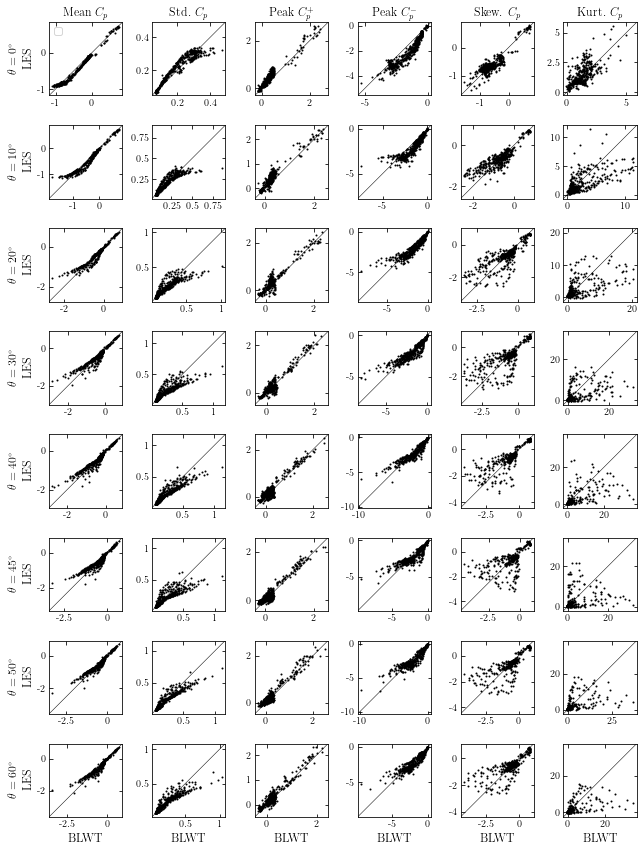

No handles with labels found to put in legend.


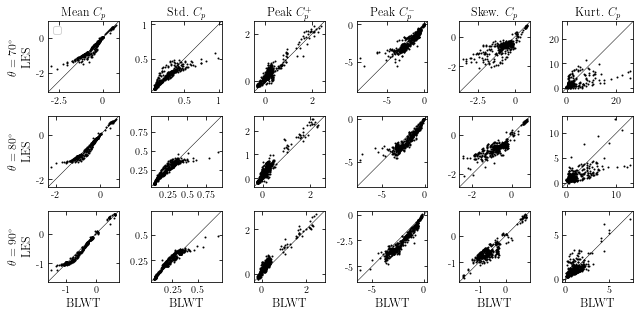

In [ ]:

fig, _ = validator_2.plotError_CpStats_perAoA(targetLabel='BLWT', modelLabel='LES', AoA_list=WT_cp.AoA[:8], 
                                              figsize_per_ax=[1.5,1.5],
                                              errorTypePerField = { 'mean': 'RMSE','std': 'RMSE','peakMax': 'RMSE','peakMin': 'RMSE', 'skewness': 'RMSE', 'kurtosis': 'RMSE' },
                                              showErrTxt=False, AoA_txt_loc=(-0.5, 0.5),
                                              kwargs_mainPlot = { 'color': 'k','marker': '.','linestyle': '', 'ms': 2 }, #abbreviateFldNames=False,
                                              kwargs_frmtAxis={'gridMajor':False, 'gridMinor':False}, percentLinesAt=[], 
                                              kwargs_AoA_label={'rotation': 90,'ha': 'center','va': 'center', 'fontsize': 12,}
                                              )
fig.savefig(figDir+'CpStatsError_perAoA_p1.png', bbox_inches='tight', dpi=300)
fig.savefig(figDir+'CpStatsError_perAoA_p1.pdf', bbox_inches='tight', dpi=300)

fig, _ = validator_2.plotError_CpStats_perAoA(targetLabel='BLWT', modelLabel='LES', AoA_list=WT_cp.AoA[8:], 
                                              figsize_per_ax=[1.5,1.5],
                                              errorTypePerField = { 'mean': 'RMSE','std': 'RMSE','peakMax': 'RMSE','peakMin': 'RMSE', 'skewness': 'RMSE', 'kurtosis': 'RMSE' },
                                              showErrTxt=False, AoA_txt_loc=(-0.5, 0.5),
                                              kwargs_mainPlot = { 'color': 'k','marker': '.','linestyle': '', 'ms': 2 }, #abbreviateFldNames=False,
                                              kwargs_frmtAxis={'gridMajor':False, 'gridMinor':False}, percentLinesAt=[],
                                              kwargs_AoA_label={'rotation': 90,'ha': 'center','va': 'center', 'fontsize': 12}
                                              )
fig.savefig(figDir+'CpStatsError_perAoA_p2.png', bbox_inches='tight', dpi=300)
fig.savefig(figDir+'CpStatsError_perAoA_p2.pdf', bbox_inches='tight', dpi=300)

# fig, _ = validator_2.plotError_CpStats_perAoA(targetLabel='BLWT', modelLabel='LES', AoA_list=WT_cp.AoA[5:], figsize_per_ax=[3,3],
#                                               errorTypePerField = { 'mean': 'RMSE','std': 'RMSE','peakMax': 'RMSE','peakMin': 'RMSE', 'skewness': 'RMSE', 'kurtosis': 'RMSE' })
# fig.savefig(figDir+'CpStatsError_perAoA_p2.svg', bbox_inches='tight', dpi=300)


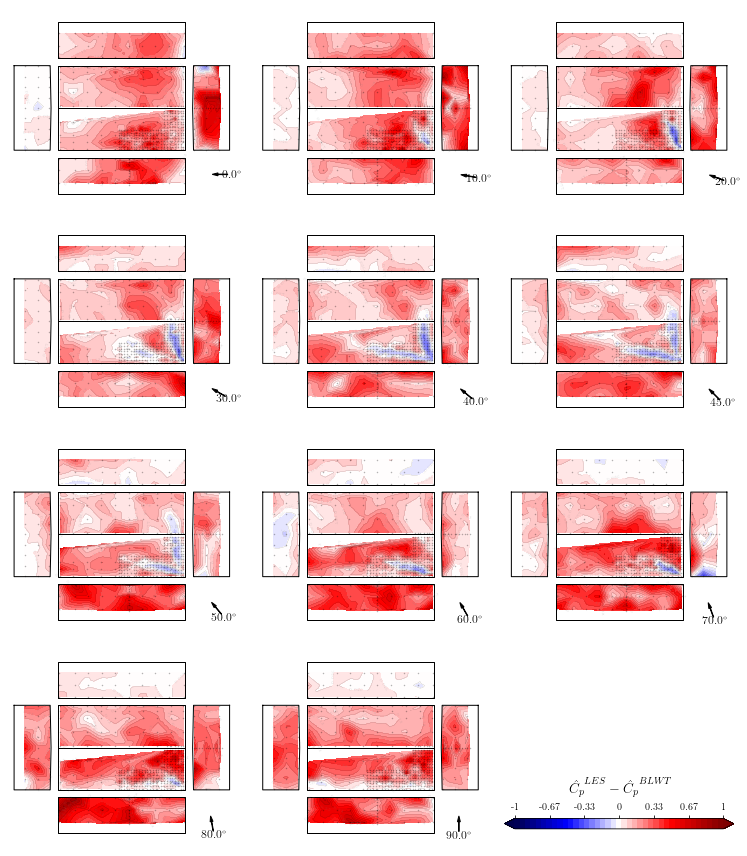

In [ ]:


# fld, fldRange = 'std', [-0.3, 0.3]
# fld, fldRange = 'mean', [-1.2, 1.2]
# fld, fldRange = 'mean', [-0.5, 0.5]
fld, fldRange = 'peakMax', [-1.0, 1.0]
# fld, fldRange = 'peakMin', [-4, 4]

fig, _ = validator.plotError_contour_CpStats(fieldName=fld, nLvl=40, figsize_per_ax=[3.5,3], AoAs=LES_Cp.AoA, 
                                             nCols=3, colBarOrientation='horizontal', tLbl='BLWT', mLbl='LES', normalizedError=False,
                                            showValuesOnContour=True, cmap='seismic',
                                            fldRange=fldRange,
                                            )

# fig.savefig(figDir+'CpStatsError_contour_'+fld+'_new.png', bbox_inches='tight')
# fig.savefig(figDir+'CpStatsError_contour_'+fld+'_new.pdf', bbox_inches='tight')


### $C_p$ Plots

In [ ]:
print(validator.error_velStats.keys())
print(validator.error_velStats['Iu'].keys())

print(validator.error_velStats['Iu']['RMSE'])
print(validator.error_velStats['Iv']['RMSE'])
print(validator.error_velStats['Iw']['RMSE'])
print(validator.error_velStats['xLu']['NRMSE'])

dict_keys(['U', 'V', 'W', 'Iu', 'Iv', 'Iw', 'xLu', 'xLv', 'xLw', 'uv', 'uw', 'vw'])
dict_keys(['MAE', 'RMSE', 'NMAE', 'NRMSE'])
0.010158159309953946
0.004345745256912807
0.007571903113020507
0.2457260963785062


Number of member bldgs: 2
TO DO: avoid displaying 'nan'. Instead display '-'


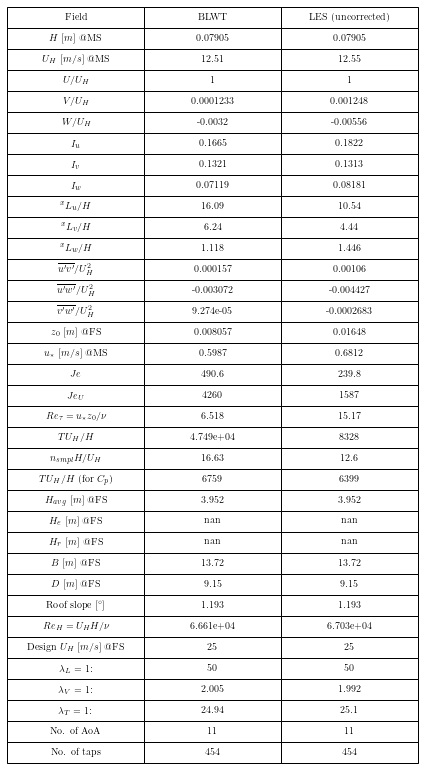

In [ ]:
WT_cp.name = 'BLWT'
cps = wind.BldgCps([WT_cp, LES_Cp])

fig, _ = cps.plotParamsTable()

if saveFigs:
    fig.savefig(figDir+"paramsTable.svg",format='svg',dpi=1200, bbox_inches='tight')
    fig.savefig(figDir+"paramsTable.pdf",format='pdf',dpi=1200, bbox_inches='tight')
    


#### Local pressure

In [ ]:
# LES_Cp.plotTapCpStatsPerAoA(fldRange=[-8,2.3],#xticks=np.round(LES_Cp.AoA,0),
#                             pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

# lesCp_E2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(lesCp_E2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

In [ ]:
zoneDictKeys = LES_Cp.zoneDictKeys

area = {z: np.array(LES_Cp.panelAreas_groupAvg[z], dtype=float)*areaFactor_toFSm2 for z in zoneDictKeys}

peakMax_les = LES_Cp.CpAavg_envMax_peakMax_maxPerA
peakMin_les = LES_Cp.CpAavg_envMin_peakMin_minPerA

valueScaleFactor_les = LES_Cp.CandCLoad_factor(debugMode=False, format='ASCE')
peakMax_les = {z: np.array(peakMax_les[z])*valueScaleFactor_les for z in zoneDictKeys}
peakMin_les = {z: np.array(peakMin_les[z])*valueScaleFactor_les for z in zoneDictKeys}



# the same for WT_cp_avg in place of LES_Cp
peakMax_wt = WT_cp_avg.CpAavg_envMax_peakMax_maxPerA
peakMin_wt = WT_cp_avg.CpAavg_envMin_peakMin_minPerA

valueScaleFactor_wt = WT_cp_avg.CandCLoad_factor(debugMode=False, format='ASCE')
peakMax_wt = {z: np.array(peakMax_wt[z])*valueScaleFactor_wt for z in zoneDictKeys}
peakMin_wt = {z: np.array(peakMin_wt[z])*valueScaleFactor_wt for z in zoneDictKeys}

# for all zones, calculate the maximum and minimum difference 'LES - WT'
peakMax_diff = {z: peakMax_les[z] - peakMax_wt[z] for z in zoneDictKeys}
peakMin_diff = {z: peakMin_les[z] - peakMin_wt[z] for z in zoneDictKeys}

# get the maximum and minimum absolute difference, but keep the sign of the difference
peakMax_diff_max_sign = {z: np.where(np.abs(peakMax_diff[z]) == np.max(np.abs(peakMax_diff[z])), peakMax_diff[z], np.nan) for z in zoneDictKeys}
peakMin_diff_max_sign = {z: np.where(np.abs(peakMin_diff[z]) == np.max(np.abs(peakMin_diff[z])), peakMin_diff[z], np.nan) for z in zoneDictKeys}
peakMax_diff_abs = {z: np.abs(peakMax_diff[z]) for z in zoneDictKeys}
peakMin_diff_abs = {z: np.abs(peakMin_diff[z]) for z in zoneDictKeys}
peakMax_diff_abs_max = {z: np.max(peakMax_diff_abs[z]) for z in zoneDictKeys}
peakMin_diff_abs_max = {z: np.max(peakMin_diff_abs[z]) for z in zoneDictKeys}

# for minimum difference:
peakMax_diff_min_sign = {z: np.where(np.abs(peakMax_diff[z]) == np.min(np.abs(peakMax_diff[z])), peakMax_diff[z], np.nan) for z in zoneDictKeys}
peakMin_diff_min_sign = {z: np.where(np.abs(peakMin_diff[z]) == np.min(np.abs(peakMin_diff[z])), peakMin_diff[z], np.nan) for z in zoneDictKeys}
peakMax_diff_abs_min = {z: np.min(peakMax_diff_abs[z]) for z in zoneDictKeys}
peakMin_diff_abs_min = {z: np.min(peakMin_diff_abs[z]) for z in zoneDictKeys}

# print the maximum and minimum absolute differences by zone
print('Maximum absolute difference in peakMax:')
for z in zoneDictKeys:
    print(f'{z}: {peakMax_diff_abs_max[z]:.3f}')
print('Minimum absolute difference in peakMax:')
for z in zoneDictKeys:
    print(f'{z}: {peakMax_diff_abs_min[z]:.3f}')
print('Maximum absolute difference in peakMin:')
for z in zoneDictKeys:
    print(f'{z}: {peakMin_diff_abs_max[z]:.3f}')
print('Minimum absolute difference in peakMin:')
for z in zoneDictKeys:
    print(f'{z}: {peakMin_diff_abs_min[z]:.3f}')
    
    

Maximum absolute difference in peakMax:
ASCE 7-22, Zone 3: 0.105
ASCE 7-22, Zone 2: 0.132
ASCE 7-22, Zone 1: 0.142
ASCE 7-22, Zone 4: 0.095
ASCE 7-22, Zone 5: 0.174
Minimum absolute difference in peakMax:
ASCE 7-22, Zone 3: 0.011
ASCE 7-22, Zone 2: 0.024
ASCE 7-22, Zone 1: 0.047
ASCE 7-22, Zone 4: 0.017
ASCE 7-22, Zone 5: 0.132
Maximum absolute difference in peakMin:
ASCE 7-22, Zone 3: 1.377
ASCE 7-22, Zone 2: 0.537
ASCE 7-22, Zone 1: 0.302
ASCE 7-22, Zone 4: 0.161
ASCE 7-22, Zone 5: 0.680
Minimum absolute difference in peakMin:
ASCE 7-22, Zone 3: 0.308
ASCE 7-22, Zone 2: 0.145
ASCE 7-22, Zone 1: 0.139
ASCE 7-22, Zone 4: 0.112
ASCE 7-22, Zone 5: 0.024


#### Area averaged load

Computing C&C Load factor for LES (uncorrected) ...
full_scale_duration = 1011.5789258731799
z0 = 0.00033m (@MS), 0.0165m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 ASCE
z0		0.0165 		---> 	 0.03	===>	1.08
Z		3.95 		---> 	 10	===>	0.731
gust_dur	1011.6 		---> 	 3	===>	0.469
			COMBINED FACTOR			0.3706

C&C factor for case LES (uncorrected) = 0.3705675379803863
Computing C&C Load factor for BLWT (avg.) ...
full_scale_duration = 1068.5225712663935
z0 = 0.000161m (@MS), 0.00806m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 ASCE
z0		0.00806 		---> 	 0.03	===>	1.17
Z		3.95 		---> 	 10	===>	0.756
gust_dur	1068.5 		---> 	 3	===>	0.468
			COMBINED FACTOR			0.4128

C&C factor for case BLWT (avg.) = 0.4127501493466178
Computing C&C Load factor for BLWT (all runs) ...
full_scale_duration = 1068.52257126

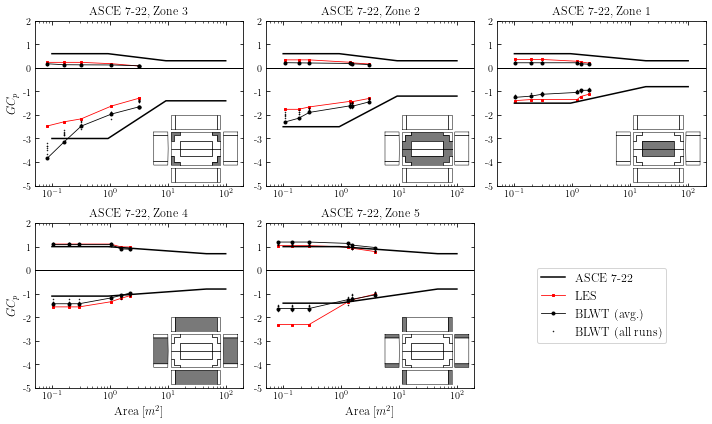

Saved figure: D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/__plots/CandC_small.png


In [ ]:
# fig = plt.figure(figsize=[7,8]) # for thesis document
fig = plt.figure(figsize=[10,6]) # for ppt
plt.tight_layout()

NumZones = bldg.NumZones
nCols = min(3, NumZones)
nRows = int(np.ceil(NumZones/nCols))
axs = fig.subplots(nRows, nCols, sharex=False, sharey=False)

for I, zKey in enumerate(bldg.zoneDictKeys):
    i, j = np.unravel_index(I, axs.shape)
    ax = axs[i,j]
    ax.set_title(zKey)
    if i == axs.shape[0]-1:
        ax.set_xlabel(r'Area [$m^2$]')
    if j == 0:
        ax.set_ylabel(r"$GC_p$")
    ax.set_xlim([0.05,200])
    ax.set_ylim([-5,2])

    wind.formatAxis(ax, gridMajor=False, gridMinor=False)

directionalityFactor = 1.0 #0.85
cols = ['r','k',]
mrkrs = ['s','o',]
ls = ['-','-',]
ms = [2,3,]
names = ['LES', 'BLWT (avg.)', 'BLWT (all runs)']
data = [LES_Cp, WT_cp_avg, ]
for cp in WT_cp_all.memberBldgs:
    data.append(cp)
    names.append('')
    cols.append('k')
    mrkrs.append('.')
    ls.append('')
    ms.append(1)
for i, cp in enumerate(data):
    if i == 0:
        overlayThese=[
                # windCodes.NBCC2020_CpCg(Figure='4.1.7.6.-C', subfig='a'),
                windCodes.ASCE7_22_GCp(Figure='30.3-2C', subfig='a', outAs='ASCE'),
                ]
        overlayFactors=[
            # 1.0/(directionalityFactor * (windCodes.getDurstFactor(3.0))**2),
            1.0,
            ]
        kwargs_overlay=(
            {'color':'k',}, 
            # {'color':'k', 'linestyle':'--'},
            )
        subplotLabels=None #['(a)','(b)','(c)','(d)','(e)','']
        plotZoneGeom=True
    else:
        overlayThese=None
        overlayFactors=None
        kwargs_overlay=({},)
        subplotLabels=None
        plotZoneGeom=False

    _ = cp.plotCandC_load(fig=fig, axs=axs, 
                            # figSize=[12.5,12.5], 
                            sharex=False, sharey=False,
                            plotExtremesPerNominalArea=True, areaFactor=areaFactor_toFSm2,
                            # xLimits=[0.1,100], yLimits=[-5,1],
                            debugMode=True,
                            CandCLoadFormat='ASCE',
                            yLabel=r"$GC_p$",
                            label_min=names[i], label_max=None,
                            kwargs_min={'color':cols[i], 'marker':mrkrs[i], 'ms':ms[i], 'ls':ls[i], 'lw': 0.8},
                            kwargs_max={'color':cols[i], 'marker':mrkrs[i], 'ms':ms[i], 'ls':ls[i], 'lw': 0.8},
                            overlayThese=overlayThese,
                            overlayFactors=overlayFactors,
                            kwargs_overlay=kwargs_overlay,
                            legend_ax_idx=5,
                            kwargs_legend={'loc':'center', 'fontsize':12},
                            subplotLabels=subplotLabels, subplotLabels_xy=[0.88,0.9],
                            kwargs_ax={'gridMinor':True},
                            plotZoneGeom=plotZoneGeom, insetBounds=[0.55,0.01,0.445,0.43], insetAxAlpha=0.2,
                            )

# relax the space between subplots
plt.tight_layout()

plt.show()

if saveFigs:
    # fig.savefig(figDir+"CandC_small.svg",format='svg',dpi=1200, bbox_inches='tight')
    # print(f"Saved figure: {figDir}CandC_Fig_E_iso.svg")
    # export to pdf instead of svg to avoid the issue of the legend not showing up in the svg file
    # fig.savefig(figDir+"CandC_small.png",format='png',dpi=1200, bbox_inches='tight')
    fig.savefig(figDir+"CandC_small.svg",format='svg',dpi=300, bbox_inches='tight')
    # fig.savefig(figDir+"CandC_small.pdf",format='pdf',dpi=1200, bbox_inches='tight')
    print(f"Saved figure: {figDir}CandC_small.png")


# Validate the aerodynamics with line plots (to be implemented)

# Manual plots

C:\Users\Tsinu\AppData\Local\Temp\ipykernel_44036\2997955584.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$p_0$', '$p_1$', '$p_2$', '...', '$p_N$'])


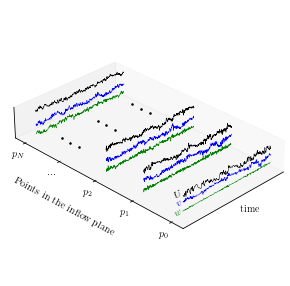

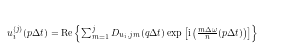

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# open a 3D plot figure
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')

# add a bunch of 2D plots with different fixed z values
i = 2000
dv = 0.0
dw = -10.0
lw = 0.5
x = lesVel_E2.t[:i]

y1 = lesVel_E2.UofT[8,:i]
y2 = lesVel_E2.UofT[10,:i]
y3 = lesVel_E2.UofT[12,:i]
y4 = lesVel_E2.UofT[14,:i]
y5 = lesVel_E2.UofT[16,:i]

# plot the 2D plots
I, zs = 2, 0.0
ax.plot(x, lesVel_E2.UofT[I,:i], zs=zs, zdir='y', color='k', lw = lw, label='$U(t)$')
ax.plot(x, lesVel_E2.VofT[I,:i]+dv, zs=zs, zdir='y', color='b', lw = lw, label='$v(t)$')
ax.plot(x, lesVel_E2.WofT[I,:i]+dw, zs=zs, zdir='y', color='g', lw = lw, label='$w(t)$')

I, zs = 20, 0.1
ax.plot(x, lesVel_E2.UofT[I,:i], zs=zs, zdir='y', color='k', lw = lw)
ax.plot(x, lesVel_E2.VofT[I,:i]+dv, zs=zs, zdir='y', color='b', lw = lw)
ax.plot(x, lesVel_E2.WofT[I,:i]+dw, zs=zs, zdir='y', color='g', lw = lw)

I, zs = 30, 0.2
ax.plot(x, lesVel_E2.UofT[I,:i], zs=zs, zdir='y', color='k', lw = lw)
ax.plot(x, lesVel_E2.VofT[I,:i]+dv, zs=zs, zdir='y', color='b', lw = lw)
ax.plot(x, lesVel_E2.WofT[I,:i]+dw, zs=zs, zdir='y', color='g', lw = lw)

# plot dots between zs = 0.25 and zs = 0.45
ax.plot([0.275, 0.3, 0.325], [0,0,0], zs=0.0, zdir='x', color='k', lw = 1, ls='None', marker='.', ms=3)
ax.plot([0.275, 0.3, 0.325], [0,0,0], zs=0.4, zdir='x', color='k', lw = 1, ls='None', marker='.', ms=3)
ax.plot([0.275, 0.3, 0.325], [0,0,0], zs=0.8, zdir='x', color='k', lw = 1, ls='None', marker='.', ms=3)


I, zs = 48, 0.4
ax.plot(x, lesVel_E2.UofT[I,:i], zs=zs, zdir='y', color='k', lw = lw)
ax.plot(x, lesVel_E2.VofT[I,:i]+dv, zs=zs, zdir='y', color='b', lw = lw)
ax.plot(x, lesVel_E2.WofT[I,:i]+dw, zs=zs, zdir='y', color='g', lw = lw)


ax.text(0, 0.0, 8, r'$U$', zdir='x', color='k', #fontsize=10,
         verticalalignment='center', 
        horizontalalignment='right', bbox=dict(boxstyle="round", fc="None", ec="None", pad=0.2))
ax.text(0, 0.0, -2, r'$v$', zdir='x', color='b',
        fontsize=10, verticalalignment='center', 
        horizontalalignment='right', bbox=dict(boxstyle="round", fc="None", ec="None", pad=0.2))
ax.text(0, 0.0, -12, r'$w$', zdir='x', color='g',
        fontsize=10, verticalalignment='center', 
        horizontalalignment='right', bbox=dict(boxstyle="round", fc="None", ec="None", pad=0.2))


# ax.legend(bbox_to_anchor=(0.8, 0.8), loc='center', ncol=1)
ax.set_xlim(-0.1, max(x))
# ax.set_xlim(0, 1)
# ax.set_zlim(-0.1, 0.1)
ax.set_xlabel('time', labelpad=-10)
ax.set_ylabel('Points in the inflow plane', labelpad=20)
# ax.set_zlabel('z')

ax.set_zticklabels([])
ax.set_yticklabels(['$p_0$', '$p_1$', '$p_2$', '...', '$p_N$'])
ax.set_xticklabels([])
ax.set_zticks([])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_xticks([])

ax.view_init(elev=30, azim=-135)

ax.set_box_aspect((0.6, 1, 0.15))

ax.grid(False)

# ax.auto_scale_xyz([-0.1, 0.1], [0, 1], [-0.1, 0.1])


plt.show()

# fig.savefig(figDir+'Inflow_schematic.svg', bbox_inches='tight', dpi=300)

# a separate simple figure for the equation
fig = plt.figure(figsize=[5,0.5])
ax = fig.add_subplot()

eqn = r'$u_i^{(j)}(p\Delta t) = \mathrm{Re} \left\{ \sum_{m=1}^{j} D_{u_i,jm}(q \Delta t) \exp \left[ \mathrm{i} \left( \frac{m \Delta \omega}{n} (p \Delta t) \right) \right] \right\} $'

ax.text(0, 0, eqn, ha='left', va='center', )

ax.axis('off')
plt.show()

# fig.savefig(figDir+'Inflow_schematic_eqn.svg', bbox_inches='tight', dpi=300)